**Elo Merchant Category Recommend Competition**
* lightGBM
* Sikit-learn

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

# additional imports

import gc
from dask import bag
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import re

import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

from datetime import date, datetime
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

dev = False
use_merchant = False
is_shuffle = True

labelencoder = dict()

**Define utility functions**

In [70]:
# memory reduce function
# https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# check and show null values
def check_null_val(df) :
    cols = df.columns
    for col in cols :
        null_cnt = df[col].isnull().sum()
        if null_cnt > 0 :
            print(col, '\t', null_cnt)
            
# convert Y/N value to binary value     
def yn_binary_encode(df, column):
    df[column] = df[column].map({'Y':1, 'N':0}).astype(np.int8)
    return df[column]

# convert categorical value to ont-hot-coding
def categorical2onehot(df, features) :
    for column in features :
        unique_val = [val for val in df[column].unique().tolist() if str(val) != 'nan']
        for val in unique_val :
            new_col_name = column + '_' + str(val)
            df[new_col_name] = 0
            df.loc[df[column] == val, new_col_name] = 1
            df[new_col_name] = df[new_col_name].astype(np.int8)
    #df.drop(features, axis = 1, inplace = True)

def get_rmse(y_true, y_pred) :
     return np.sqrt(np.mean((y_true - y_pred)**2))
    
def get_agg(df, agg_dict, prefix = '', groupby='card_id') :
    df_agg = df.groupby(groupby).agg(agg_dict)
    df_agg.columns = [prefix + col[0] + '_' + col[1] for col in df_agg.columns]
    if prefix + 'purchase_date_max' in df_agg.columns and prefix + 'purchase_date_min' in df_agg.columns :
        df_agg[prefix + 'purchase_date_ptp'] = df_agg[prefix + 'purchase_date_max'] - df_agg[prefix + 'purchase_date_min']
    return df_agg

**Load  train / test data**

In [43]:
df_train = pd.read_csv("../train.csv")
df_test  = pd.read_csv("../test.csv")

print("df_train : ", df_train.shape)
print("df_test  : ", df_test.shape)
    
df_train = reduce_mem_usage(df_train)
df_test  = reduce_mem_usage(df_test)

df_train.head()

df_train :  (201917, 6)
df_test  :  (123623, 5)
Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)


,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790


**Load transaction data**

In [44]:
df_his_tran = pd.read_csv("C:/Users/user/Documents/Salamat/ELO/historical_transactions.csv")
df_his_tran = reduce_mem_usage(df_his_tran)
print("df_his_tran          : ", df_his_tran.shape)

df_new_tran = pd.read_csv("C:/Users/user/Documents/Salamat/ELO/new_merchant_transactions.csv")
df_new_tran = reduce_mem_usage(df_new_tran)
print("df_new_merchant_trans: ", df_new_tran.shape)

gc.collect()
df_his_tran.head()

Mem. usage decreased to 1749.11 Mb (43.7% reduction)
df_his_tran          :  (29112361, 14)
Mem. usage decreased to 114.20 Mb (45.5% reduction)
df_new_merchant_trans:  (1963031, 14)


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [45]:
# fast way to get last historic transaction / first new transaction
last_hist_transaction = df_his_tran.groupby('card_id').agg({'month_lag' : 'max', 'purchase_date' : 'max'}).reset_index()
last_hist_transaction.columns = ['card_id', 'hist_month_lag', 'hist_purchase_date']

# converting to datetime
last_hist_transaction['hist_purchase_date'] = pd.to_datetime(last_hist_transaction['hist_purchase_date']) 

# substracting month_lag for each row
last_hist_transaction['observation_date'] = \
    last_hist_transaction.apply(lambda x: x['hist_purchase_date']  - pd.DateOffset(months=x['hist_month_lag']), axis=1)

last_hist_transaction['observation_date'] = last_hist_transaction['observation_date'].dt.to_period('M').dt.to_timestamp() + pd.DateOffset(months=1)

df_train = df_train.merge(last_hist_transaction[['card_id','observation_date']], on = 'card_id')
df_test = df_test.merge(last_hist_transaction[['card_id','observation_date']], on = 'card_id')

temp = df_his_tran.groupby('card_id').agg({'purchase_date':['min','max']})
temp.columns = ['his_first_date', 'his_last_date']
#Let's reset index
temp.reset_index(inplace=True)

df_train = df_train.merge(temp, how='left', on='card_id')
df_test = df_test.merge(temp, how='left', on='card_id')


temp = df_new_tran.groupby('card_id').agg({'purchase_date':['min','max']})
temp.columns = ['new_first_date', 'new_last_date']

#Let's reset index
temp.reset_index(inplace=True)


df_train = df_train.merge(temp, how='left', on='card_id')
df_test = df_test.merge(temp, how='left', on='card_id')

for col in ['his_first_date', 'new_first_date', 'his_last_date', 'new_last_date'] :
    df_train['obv_' + col + '_diff'] = (pd.to_datetime(df_train[col]) - df_train['observation_date']).apply(lambda x : abs(x.days))
    df_test['obv_' + col + '_diff'] = (pd.to_datetime(df_train[col]) - df_test['observation_date']).apply(lambda x : abs(x.days))
    
df_train.drop(['observation_date', 'his_first_date', 'new_first_date', 'his_last_date', 'new_last_date'], axis =1, inplace = True)
df_test.drop(['observation_date', 'his_first_date', 'new_first_date', 'his_last_date', 'new_last_date'], axis =1, inplace = True)
 
df_train = reduce_mem_usage(df_train)
df_test  = reduce_mem_usage(df_test)
    
df_train.head()

Mem. usage decreased to 17.12 Mb (21.3% reduction)
Mem. usage decreased to  9.13 Mb (23.7% reduction)


,first_active_month,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,109,1.0,1,58.0


In [46]:
df_test['first_active_month'].fillna(value='2017-01', inplace = True)
df_agg = df_his_tran.groupby('card_id',as_index=False).agg({'purchase_date' : 'min', 'month_lag' : 'min'})
df_train = df_train.merge(df_agg, how='left', on='card_id')
df_test = df_test.merge(df_agg, how='left', on='card_id')


In [47]:
del df_agg
gc.collect()

df_train['purchase_date'] = df_train['purchase_date'].apply(lambda x : x[:4] + '-' + x[5:7])
df_test['purchase_date'] = df_test['purchase_date'].apply(lambda x : x[:4] + '-' + x[5:7])

df_train.loc[df_train['first_active_month']>df_train['purchase_date'], 'first_active_month'] = df_train.loc[df_train['first_active_month']>df_train['purchase_date'], 'purchase_date']
df_test.loc[df_test['first_active_month']>df_test['purchase_date'], 'first_active_month'] = df_test.loc[df_test['first_active_month']>df_test['purchase_date'], 'purchase_date']

max_date = df_new_tran['purchase_date'].max()
max_date = datetime(int(max_date[:4]), int(max_date[5:7]), int(max_date[8:10]))

df_train['active_period'] = df_train['first_active_month'].apply(lambda x : (max_date - datetime(int(x[:4]), int(x[5:7]), 1)).days).astype(np.int32)
df_test['active_period']  = df_test['first_active_month'].apply(lambda x : (max_date - datetime(int(x[:4]), int(x[5:7]), 1)).days).astype(np.int32)

df_train.drop(['first_active_month'], axis = 1, inplace = True)
df_test.drop(['first_active_month'], axis = 1, inplace = True)

In [48]:
# use purchase_date column as elapsed time feature
df_new_tran['purchase_date'] = df_new_tran['purchase_date'].apply(lambda x : (max_date - datetime(int(x[:4]), int(x[5:7]), int(x[8:10]))).days)
df_his_tran['purchase_date'] = df_his_tran['purchase_date'].apply(lambda x : (max_date - datetime(int(x[:4]), int(x[5:7]), int(x[8:10]))).days)

df_new_tran['month_diff'] = (df_new_tran['purchase_date']/30) + df_new_tran['month_lag'] 
df_his_tran['month_diff'] = (df_his_tran['purchase_date']/30) + df_his_tran['month_lag'] 

#df_new_tran['duration'] = df_new_tran['purchase_amount'].clip(-1, 1)*df_new_tran['month_diff']
#df_his_tran['duration'] = df_his_tran['purchase_amount'].clip(-1, 1)*df_his_tran['month_diff']

active_period = pd.concat([df_train[['card_id', 'active_period']], df_test[['card_id', 'active_period']]])

df_his_tran = df_his_tran.merge(active_period, how='left', on='card_id')
df_his_tran['active_purchase_diff'] = df_his_tran['active_period'] - df_his_tran['purchase_date']
df_his_tran.drop(['active_period'], axis = 1, inplace = True)

df_new_tran = df_new_tran.merge(active_period, how='left', on='card_id')
df_new_tran['active_purchase_diff'] = df_new_tran['active_period'] - df_new_tran['purchase_date']
df_new_tran.drop(['active_period'], axis = 1, inplace = True)

del active_period

In [49]:
# del active_period

# add positive biased value for summatoin
min_amount = max(abs(df_his_tran['purchase_amount'].min()), abs(df_new_tran['purchase_amount'].min()))
df_his_tran['purchase_amount_pos'] = df_his_tran['purchase_amount'] + min_amount + 0.000001
df_new_tran['purchase_amount_pos'] = df_new_tran['purchase_amount'] + min_amount + 0.000001

# binarize value
df_his_tran['authorized_flag'] = yn_binary_encode(df_his_tran, 'authorized_flag')
df_his_tran['category_1'] = yn_binary_encode(df_his_tran,'category_1')

df_new_tran['authorized_flag'] = yn_binary_encode(df_new_tran, 'authorized_flag')
df_new_tran['category_1'] = yn_binary_encode(df_new_tran, 'category_1')

df_his_tran['installments'] = df_his_tran['installments'].clip(0, 12)
df_new_tran['installments'] = df_new_tran['installments'].clip(0, 12)

categorical_columns = ['category_3', 'category_2']
categorical2onehot(df_his_tran, categorical_columns)
categorical2onehot(df_new_tran, categorical_columns)



In [50]:
df_merchants = pd.read_csv("../../../ELO/merchants.csv")
print("df_merchants : ", df_merchants.shape)

df_merchants['category_4'] = yn_binary_encode(df_merchants, 'category_4')
df_merchants = reduce_mem_usage(df_merchants).groupby('merchant_id',as_index=False).agg({
      'merchant_group_id'       : 'min'
    , 'category_4'              : 'mean'
    #, 'most_recent_sales_range' : 'mean'
    #, 'numerical_1'             : 'mean'
})
df_his_tran = df_his_tran.merge(df_merchants, how='left', on='merchant_id')
df_new_tran = df_new_tran.merge(df_merchants, how='left', on='merchant_id')
del df_merchants

df_his_tran['month_rank'] = df_his_tran.groupby(['card_id'])['month_lag'].rank(method='dense',ascending=False)
df_new_tran['month_rank'] = df_new_tran.groupby(['card_id'])['month_lag'].rank(method='dense',ascending=False)

df_his_tran['month_rank_reverse'] = df_his_tran.groupby(['card_id'])['month_lag'].rank(method='dense',ascending=True)
df_new_tran['month_rank_reverse'] = df_new_tran.groupby(['card_id'])['month_lag'].rank(method='dense',ascending=True)

df_his_tran['date_rank'] = df_his_tran.groupby(['card_id'])['purchase_date'].rank(method='dense',ascending=True)
df_new_tran['date_rank'] = df_new_tran.groupby(['card_id'])['purchase_date'].rank(method='dense',ascending=True)

df_his_tran['date_rank_reverse'] = df_his_tran.groupby(['card_id'])['purchase_date'].rank(method='dense',ascending=False)
df_new_tran['date_rank_reverse'] = df_new_tran.groupby(['card_id'])['purchase_date'].rank(method='dense',ascending=False)

df_his_tran['amount_rank'] = df_his_tran.groupby(['card_id'])['purchase_amount'].rank(method='dense',ascending=False)
df_new_tran['amount_rank'] = df_new_tran.groupby(['card_id'])['purchase_amount'].rank(method='dense',ascending=False)

df_his_tran = reduce_mem_usage(df_his_tran)
df_new_tran = reduce_mem_usage(df_new_tran)

gc.collect()
df_his_tran.head()

df_merchants :  (334696, 22)
Mem. usage decreased to 28.09 Mb (47.9% reduction)
Mem. usage decreased to 3556.62 Mb (33.0% reduction)
Mem. usage decreased to 226.02 Mb (32.8% reduction)


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,category_2_5.0,category_2_2.0,category_2_4.0,merchant_group_id,category_4,month_rank,month_rank_reverse,date_rank,date_rank_reverse,amount_rank
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,...,0,0,0,35.0,1.0,9.0,6.0,125.0,76.0,29.0
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,...,0,0,0,2084.0,1.0,8.0,7.0,111.0,90.0,111.0
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,...,0,0,0,27369.0,1.0,7.0,8.0,102.0,99.0,59.0
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,...,0,0,0,24104.0,1.0,6.0,9.0,79.0,122.0,124.0
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,...,0,0,0,35.0,1.0,12.0,3.0,192.0,9.0,67.0


In [58]:
# get reference date difference of each date in transactions

temp = df_his_tran.groupby('card_id',as_index=False).agg({'purchase_date' : 'min'})
temp.columns = ['card_id','min_date']
df_his_tran = df_his_tran.merge(temp, how='left', on='card_id')
df_his_tran = df_his_tran.merge(pd.concat([df_train[['card_id', 'obv_his_last_date_diff']], df_test[['card_id', 'obv_his_last_date_diff']]]))
df_his_tran['ref_diff'] = df_his_tran['obv_his_last_date_diff'] + (df_his_tran['purchase_date'] - df_his_tran['min_date'])
df_his_tran.drop(['min_date', 'obv_his_last_date_diff'], axis = 1, inplace = True)

temp = df_new_tran.groupby('card_id',as_index=False).agg({'purchase_date' : 'max'})
temp.columns = ['card_id','max_date']
df_new_tran = df_new_tran.merge(temp, how='left', on='card_id')
df_new_tran = df_new_tran.merge(pd.concat([df_train[['card_id', 'obv_new_first_date_diff']], df_test[['card_id', 'obv_new_first_date_diff']]]))
df_new_tran['ref_diff'] = df_new_tran['obv_new_first_date_diff'] + (df_new_tran['max_date'] - df_new_tran['purchase_date'])
df_new_tran.drop(['max_date', 'obv_new_first_date_diff'], axis = 1, inplace = True)

del temp
gc.collect()

df_his_tran.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,category_2_2.0,category_2_4.0,merchant_group_id,category_4,month_rank,month_rank_reverse,date_rank,date_rank_reverse,amount_rank,ref_diff
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,...,0,0,35.0,1.0,9.0,6.0,125.0,76.0,29.0,251.0
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,...,0,0,2084.0,1.0,8.0,7.0,111.0,90.0,111.0,231.0
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,...,0,0,27369.0,1.0,7.0,8.0,102.0,99.0,59.0,206.0
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,...,0,0,24104.0,1.0,6.0,9.0,79.0,122.0,124.0,182.0
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,...,0,0,35.0,1.0,12.0,3.0,192.0,9.0,67.0,358.0


In [72]:
# get agg based on date rank

agg_dict = {
     'card_id'          : ['count']
    ,'purchase_amount'  : ['max', 'min']
    ,'installments'     : ['max', 'sum']
    ,'merchant_id'      : ['nunique']
    ,'merchant_group_id': ['nunique']
    ,'category_1'       : ['mean']
}

for rank in range(1, 2) :
    df_agg = get_agg(df_new_tran.loc[df_new_tran['date_rank']==rank, list(agg_dict.keys())]
                     , agg_dict, prefix = 'new_date_' + str(rank) + '_')
    df_agg.reset_index(inplace=True)
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    
for rank in range(1, 2) :
    df_agg = get_agg(df_new_tran.loc[df_new_tran['date_rank_reverse']==rank, list(agg_dict.keys())]
                     , agg_dict, prefix = 'new_date_reverse_' + str(rank) + '_')
    df_agg.reset_index(inplace=True)
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    
for rank in range(1, 2) :
    df_agg = get_agg(df_his_tran.loc[df_his_tran['date_rank']==rank, list(agg_dict.keys())]
                     , agg_dict, prefix = 'his_date_' + str(rank) + '_')
    df_agg.reset_index(inplace=True)
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    
for rank in range(1, 2) :
    df_agg = get_agg(df_his_tran.loc[df_his_tran['date_rank_reverse']==rank, list(agg_dict.keys())]
                     , agg_dict, prefix = 'his_date_reverse_' + str(rank) + '_')
    df_agg.reset_index(inplace=True)
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    
print(df_train.shape)
df_train.head()

(201917, 44)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,purchase_date,...,his_date_1_merchant_group_id_nunique,his_date_1_category_1_mean,his_date_reverse_1_card_id_count,his_date_reverse_1_purchase_amount_max,his_date_reverse_1_purchase_amount_min,his_date_reverse_1_installments_max,his_date_reverse_1_installments_sum,his_date_reverse_1_merchant_id_nunique,his_date_reverse_1_merchant_group_id_nunique,his_date_reverse_1_category_1_mean
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2017-06,...,2,0.0,1,-0.710529,-0.710529,0,0.0,1,1,0.0
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2017-01,...,2,0.0,2,-0.677560,-0.686952,1,2.0,2,1,0.0
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2017-01,...,1,0.0,2,-0.718508,-0.719860,0,0.0,2,2,0.0
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2017-09,...,1,0.0,1,-0.739410,-0.739410,1,1.0,1,1,0.0
4,C_ID_cdbd2c0db2,1,3,0,-0.159790,109,1.0,1,58.0,2017-11,...,4,0.2,2,-0.633352,-0.652692,1,2.0,2,2,0.0


In [73]:
# get agg based on aount rank

agg_dict = {
     'card_id'          : ['count']
    ,'purchase_date'    : ['min']
    ,'month_lag'        : ['max']
    ,'ref_diff'         : ['min', 'mean']
    ,'installments'     : ['max', 'sum']
    ,'merchant_id'      : ['nunique']
    ,'category_1'       : ['mean']
}

for rank in range(1, 2) :
    df_agg = get_agg(df_new_tran.loc[df_new_tran['amount_rank']==rank, list(agg_dict.keys())]
                     , agg_dict, prefix = 'new_amount_rank' + str(rank) + '_')
    df_agg.reset_index(inplace=True)
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

for rank in range(1, 2) :
    df_agg = get_agg(df_his_tran.loc[df_his_tran['amount_rank']==rank, list(agg_dict.keys())]
                     , agg_dict, prefix = 'his_amount_rank' + str(rank) + '_')
    df_agg.reset_index(inplace=True)
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    
print(df_train.shape)
df_train.head()

(201917, 62)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,purchase_date,...,new_amount_rank1_category_1_mean,his_amount_rank1_card_id_count,his_amount_rank1_purchase_date_min,his_amount_rank1_month_lag_max,his_amount_rank1_ref_diff_min,his_amount_rank1_ref_diff_mean,his_amount_rank1_installments_max,his_amount_rank1_installments_sum,his_amount_rank1_merchant_id_nunique,his_amount_rank1_category_1_mean
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2017-06,...,0.0,1,138,-2,78.0,78.0,0,0.0,1,0.0
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2017-01,...,0.0,1,475,-12,387.0,387.0,2,2.0,1,1.0
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2017-01,...,0.0,1,93,-1,33.0,33.0,0,0.0,1,0.0
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2017-09,...,0.0,1,157,-3,97.0,97.0,1,1.0,1,1.0
4,C_ID_cdbd2c0db2,1,3,0,-0.159790,109,1.0,1,58.0,2017-11,...,0.0,2,62,0,2.0,2.0,12,24.0,1,1.0


In [74]:
# get agg based on month rank

agg_dict = {
     'card_id'             : ['count']
    
    ,'purchase_date'       : ['min', 'max', 'mean', 'std', 'nunique']
    ,'month_diff'          : ['mean']
    
    ,'ref_diff'            : ['mean']
     
    ,'purchase_amount'     : ['min', 'max', 'mean', 'std']
    ,'purchase_amount_pos' : ['sum']
    ,'installments'        : ['min', 'max', 'sum']
    
    ,'category_1'   : ['mean']
    #,'category_3_A' : ['mean']
    ,'category_3_B' : ['mean']
    #,'category_3_C' : ['mean']
    ,'category_4'   : ['mean']
    
    ,'merchant_id'          : ['nunique']
    ,'merchant_category_id' : ['nunique']
    ,'merchant_group_id'    : ['nunique']
    ,'city_id'              : ['nunique']
    
    ,'authorized_flag'  : ['mean']
    
    #,'most_recent_sales_range' : ['mean']
    #,'numerical_1'             : ['mean']
}

for rank in tqdm(range(1, 3)) :
    prefix = 'month_rank_' + str(rank) + '_'
    df_agg = get_agg(df_his_tran.loc[(df_his_tran['month_rank']==rank), list(agg_dict.keys())], agg_dict, prefix = prefix)
    df_agg.reset_index(inplace=True)
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    del df_agg
    gc.collect()
    
for rank in tqdm(range(1, 2)) :
    prefix = 'new_month_rank_' + str(rank) + '_'
    df_agg = get_agg(df_new_tran.loc[(df_new_tran['month_rank']==rank), list(agg_dict.keys())], agg_dict, prefix = prefix)
    df_agg.reset_index(inplace=True)
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    del df_agg
    gc.collect()


print(df_train.shape)
df_train.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.11s/it]


(201917, 137)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,purchase_date,...,new_month_rank_1_installments_sum,new_month_rank_1_category_1_mean,new_month_rank_1_category_3_B_mean,new_month_rank_1_category_4_mean,new_month_rank_1_merchant_id_nunique,new_month_rank_1_merchant_category_id_nunique,new_month_rank_1_merchant_group_id_nunique,new_month_rank_1_city_id_nunique,new_month_rank_1_authorized_flag_mean,new_month_rank_1_purchase_date_ptp
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2017-06,...,0.0,0.00,0.00,1.000000,11.0,9.0,9.0,1.0,1.0,23.0
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2017-01,...,3.0,0.00,1.00,1.000000,3.0,3.0,3.0,1.0,1.0,10.0
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2017-01,...,0.0,0.00,0.00,1.000000,1.0,1.0,1.0,1.0,1.0,0.0
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2017-09,...,4.0,0.20,0.80,1.000000,5.0,4.0,3.0,2.0,1.0,14.0
4,C_ID_cdbd2c0db2,1,3,0,-0.159790,109,1.0,1,58.0,2017-11,...,21.0,0.05,0.95,0.600098,20.0,11.0,17.0,5.0,1.0,27.0


In [75]:
# get agg of each month lag

agg_dict = {
     'card_id'              : ['count']
    
    ,'purchase_date'        : ['min', 'max', 'nunique', 'std']
    ,'ref_diff'             : ['mean']
    
    ,'purchase_amount'      : ['min', 'max']
    ,'purchase_amount_pos'  : ['sum']
    ,'installments'         : ['min', 'max', 'sum']
    
    ,'category_1'   : ['mean']
    ,'category_3_B' : ['mean']
    ,'category_4'   : ['mean']
    
    ,'merchant_id'          : ['nunique']
    ,'merchant_category_id' : ['nunique']
    ,'merchant_group_id'    : ['nunique']
    ,'city_id'              : ['nunique']
    
    #,'authorized_flag'  : ['mean']
}

for month in tqdm(sorted(df_his_tran['month_lag'].unique().tolist())) :
    prefix = 'month' + str(month) + '_'
    df_agg = get_agg(df_his_tran.loc[df_his_tran['month_lag']==month, list(agg_dict.keys())], agg_dict, prefix = prefix)
    df_agg.reset_index(inplace=True)
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    
for month in tqdm(sorted(df_new_tran['month_lag'].unique().tolist())) :
    prefix = 'month' + str(month) + '_'
    df_agg = get_agg(df_new_tran.loc[df_new_tran['month_lag']==month, list(agg_dict.keys())], agg_dict, prefix = prefix)
    df_agg.reset_index(inplace=True)
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

del df_agg
gc.collect()

print(df_train.shape)
df_train.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.96s/it]


(201917, 457)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,purchase_date,...,month2_installments_max,month2_installments_sum,month2_category_1_mean,month2_category_3_B_mean,month2_category_4_mean,month2_merchant_id_nunique,month2_merchant_category_id_nunique,month2_merchant_group_id_nunique,month2_city_id_nunique,month2_purchase_date_ptp
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2017-06,...,0.0,0.0,0.00,0.00,1.000000,11.0,9.0,9.0,1.0,23.0
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2017-01,...,1.0,3.0,0.00,1.00,1.000000,3.0,3.0,3.0,1.0,10.0
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2017-01,...,0.0,0.0,0.00,0.00,1.000000,1.0,1.0,1.0,1.0,0.0
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2017-09,...,1.0,4.0,0.20,0.80,1.000000,5.0,4.0,3.0,2.0,14.0
4,C_ID_cdbd2c0db2,1,3,0,-0.159790,109,1.0,1,58.0,2017-11,...,2.0,21.0,0.05,0.95,0.600098,20.0,11.0,17.0,5.0,27.0


In [76]:
# get agg based on month lag range

agg_dict = {
     'card_id'             : ['count']
    
    ,'month_lag'           : ['min', 'max', 'nunique', 'std']
    ,'purchase_date'       : ['min', 'max', 'nunique', 'std']
    ,'ref_diff'            : ['mean']
    
    ,'purchase_amount'     : ['min', 'max', 'mean', 'std']
    ,'installments'        : ['max', 'sum']

    ,'category_1'          : ['mean']
    ,'category_3_B'        : ['mean']
    ,'category_4'          : ['mean']
    
    ,'merchant_id'          : ['nunique']
    ,'merchant_category_id' : ['nunique']
    ,'merchant_group_id'    : ['nunique']
    ,'city_id'              : ['nunique']
}

"""
df_agg = get_agg(df_his_tran.loc[(df_his_tran['month_lag']>-4)&(df_his_tran['authorized_flag']==1), list(agg_dict.keys())]
                 , agg_dict, prefix = 'his_month_lag_4_')

df_train = df_train.merge(df_agg, how='left', on='card_id')
df_test = df_test.merge(df_agg, how='left', on='card_id')
"""

df_agg = get_agg(df_his_tran.loc[(df_his_tran['month_lag']>-6)&(df_his_tran['authorized_flag']==1), list(agg_dict.keys())]
                 , agg_dict, prefix = 'his_month_lag_6_')
df_agg.reset_index(inplace=True)

df_train = df_train.merge(df_agg, how='left', on='card_id')
df_test = df_test.merge(df_agg, how='left', on='card_id')

"""
df_agg = get_agg(df_his_tran.loc[(df_his_tran['month_lag']>-9)&(df_his_tran['authorized_flag']==1), list(agg_dict.keys())]
                 , agg_dict, prefix = 'his_month_lag_9_')

df_train = df_train.merge(df_agg, how='left', on='card_id')
df_test = df_test.merge(df_agg, how='left', on='card_id')
"""

print(df_train.shape)
df_train.head()

(201917, 481)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,purchase_date,...,his_month_lag_6_installments_max,his_month_lag_6_installments_sum,his_month_lag_6_category_1_mean,his_month_lag_6_category_3_B_mean,his_month_lag_6_category_4_mean,his_month_lag_6_merchant_id_nunique,his_month_lag_6_merchant_category_id_nunique,his_month_lag_6_merchant_group_id_nunique,his_month_lag_6_city_id_nunique,his_month_lag_6_purchase_date_ptp
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2017-06,...,0.0,0.0,0.000000,0.000000,0.940430,77.0,40.0,59.0,6.0,176.0
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2017-01,...,10.0,238.0,0.052941,0.805882,0.888184,84.0,42.0,60.0,7.0,183.0
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2017-01,...,0.0,0.0,0.000000,0.000000,1.000000,5.0,5.0,5.0,1.0,178.0
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2017-09,...,3.0,86.0,0.155844,0.883117,0.974121,50.0,25.0,39.0,7.0,155.0
4,C_ID_cdbd2c0db2,1,3,0,-0.159790,109,1.0,1,58.0,2017-11,...,12.0,144.0,0.093750,0.968750,0.944824,65.0,26.0,51.0,6.0,108.0


In [77]:
"""
vect_dict = dict()
for col in tqdm(['subsector_id', 'merchant_category_id']) :
    temp = pd.concat([df_his_tran[['card_id',col]],df_new_tran[['card_id',col]]])
    temp[col] = temp[col].apply(lambda x : str(x) + ' ')
    temp = temp.groupby('card_id').agg({col : 'sum'})
    
    vect = CountVectorizer()
    vect = vect.fit_transform(temp[col].values)

    vect_dict[col] = [temp.reset_index()['card_id'], vect]
    
    del temp, vect
    gc.collect()
"""

# get representative subsector_id

for col in tqdm(['subsector_id']) :
    df = pd.concat([df_his_tran.loc[df_his_tran['authorized_flag']==1,['card_id', col]], df_new_tran[['card_id', col]]]).groupby(['card_id', col]).agg({col:'count'})
    df['rank'] = df.groupby('card_id')[col].rank(method='first', ascending=False)
    
    df = df.drop([col], axis = 1).reset_index()
    for rank in range(1, 2) :
        temp = df.loc[df['rank']==rank, ['card_id', col]]
        temp.columns = ['card_id', col + '_rank_' + str(rank)]
        df_train = df_train.merge(temp, how='left', on='card_id')
        df_test = df_test.merge(temp, how='left', on='card_id')
    
    del df, temp
    gc.collect()
    
print(df_train.shape)
df_train.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:16<00:00, 76.02s/it]


(201917, 482)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,purchase_date,...,his_month_lag_6_installments_sum,his_month_lag_6_category_1_mean,his_month_lag_6_category_3_B_mean,his_month_lag_6_category_4_mean,his_month_lag_6_merchant_id_nunique,his_month_lag_6_merchant_category_id_nunique,his_month_lag_6_merchant_group_id_nunique,his_month_lag_6_city_id_nunique,his_month_lag_6_purchase_date_ptp,subsector_id_rank_1
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2017-06,...,0.0,0.000000,0.000000,0.940430,77.0,40.0,59.0,6.0,176.0,34
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2017-01,...,238.0,0.052941,0.805882,0.888184,84.0,42.0,60.0,7.0,183.0,34
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2017-01,...,0.0,0.000000,0.000000,1.000000,5.0,5.0,5.0,1.0,178.0,33
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2017-09,...,86.0,0.155844,0.883117,0.974121,50.0,25.0,39.0,7.0,155.0,37
4,C_ID_cdbd2c0db2,1,3,0,-0.159790,109,1.0,1,58.0,2017-11,...,144.0,0.093750,0.968750,0.944824,65.0,26.0,51.0,6.0,108.0,37


In [78]:
# get agg based on unauthorized flag

agg_dict = {
     'card_id'             : ['count']
    
    ,'month_lag'           : ['min', 'max', 'mean', 'nunique', 'std']
    ,'purchase_date'       : ['min', 'max', 'mean', 'nunique', 'std']
    ,'active_purchase_diff': ['max']
    ,'month_diff'          : ['min', 'max', 'mean']
    
    ,'ref_diff'            : ['min', 'max', 'mean']
     
    ,'purchase_amount'     : ['min', 'max', 'mean', 'std']
    ,'installments'        : ['max', 'sum']
    ,'purchase_amount_pos' : ['sum']
    
    ,'category_1'   : ['mean']
    ,'category_3_A' : ['mean']
    ,'category_3_B' : ['mean']
    ,'category_3_C' : ['mean']
    ,'category_4'   : ['mean']
    
    ,'merchant_id'          : ['nunique']
    ,'merchant_category_id' : ['nunique']
    ,'merchant_group_id'    : ['nunique']
    ,'city_id'              : ['nunique']
    ,'state_id'             : ['nunique']
    ,'subsector_id'         : ['nunique']
}

df_agg = get_agg(df_his_tran.loc[df_his_tran['authorized_flag']==0, list(agg_dict.keys())]
                 , agg_dict, prefix = 'den_')
df_agg.reset_index(inplace=True)
df_train = df_train.merge(df_agg, how='left', on='card_id')
df_test = df_test.merge(df_agg, how='left', on='card_id')

"""
df_agg = get_agg(df_his_tran.loc[(df_his_tran['category_1']==1)&(df_his_tran['authorized_flag']==0), list(agg_dict.keys())]
                 , agg_dict, prefix = 'den_ca1_1_')

df_train = df_train.merge(df_agg, how='left', on='card_id')
df_test = df_test.merge(df_agg, how='left', on='card_id')
"""

agg_dict = {
     'card_id'             : ['count']
    
    ,'purchase_date'       : ['min', 'max', 'nunique', 'std']
    ,'month_diff'          : ['mean']
    
    ,'purchase_amount'     : ['min', 'max', 'mean', 'std']
    ,'installments'        : ['max', 'sum']
    ,'purchase_amount_pos' : ['sum']
    
    ,'category_1'   : ['mean']
    ,'category_3_A' : ['mean']
    ,'category_3_B' : ['mean']
    ,'category_3_C' : ['mean']
    ,'category_4'   : ['mean']
    
    ,'merchant_id'          : ['nunique']
    ,'merchant_category_id' : ['nunique']
    ,'merchant_group_id'    : ['nunique']
    ,'city_id'              : ['nunique']
    ,'state_id'             : ['nunique']
    ,'subsector_id'         : ['nunique']
}

"""
df_agg = get_agg(df_his_tran.loc[(df_his_tran['authorized_flag']==0)&(df_his_tran['month_rank']==1), list(agg_dict.keys())]
                 , agg_dict, prefix = 'den_month1_')

df_train = df_train.merge(df_agg, how='left', on='card_id')
df_test = df_test.merge(df_agg, how='left', on='card_id')
"""

del df_agg
gc.collect()

print(df_train.shape)
df_train.head()

(201917, 519)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,purchase_date,...,den_category_3_B_mean,den_category_3_C_mean,den_category_4_mean,den_merchant_id_nunique,den_merchant_category_id_nunique,den_merchant_group_id_nunique,den_city_id_nunique,den_state_id_nunique,den_subsector_id_nunique,den_purchase_date_ptp
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2017-06,...,0.307692,0.000000,0.916504,12.0,10.0,7.0,2.0,1.0,7.0,165.0
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2017-01,...,0.363636,0.636364,1.000000,9.0,9.0,6.0,2.0,2.0,9.0,300.0
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2017-01,...,0.000000,0.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,57.0
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2017-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C_ID_cdbd2c0db2,1,3,0,-0.159790,109,1.0,1,58.0,2017-11,...,0.400000,0.600000,1.000000,2.0,2.0,2.0,2.0,2.0,2.0,38.0


In [80]:
# get agg based on category information

for col, prefix in zip([
    'category_1',
    'category_4',
    #'category_3_A',
    #'category_3_B',
    'category_3_C']
    ,['ca1_',
      'ca4_',
      #'ca3_A_',
      #'ca3_B_',
      'ca3_C_']) :

    print(col, prefix)
    
    agg_dict = {
         'card_id'             : ['count']

        ,'month_lag'           : ['min', 'max', 'mean', 'nunique', 'std']
        ,'purchase_date'       : ['min', 'max', 'mean', 'nunique', 'std']
        ,'month_diff'          : ['mean']
        ,'ref_diff'            : ['mean', 'min', 'max']

        ,'purchase_amount'     : ['min', 'max', 'mean', 'std']
        ,'installments'        : ['min', 'max', 'sum']
        ,'purchase_amount_pos' : ['sum']

        ,'merchant_id'          : ['nunique']
        ,'merchant_category_id' : ['nunique']
        ,'merchant_group_id'    : ['nunique']
        ,'city_id'              : ['nunique']
        ,'state_id'             : ['mean']
    }
    
    df_agg = get_agg(pd.concat([
        df_his_tran.loc[(df_his_tran[col]==1)&(df_his_tran['authorized_flag']==1), list(agg_dict.keys())]
        , df_new_tran.loc[(df_new_tran[col]==1)&(df_new_tran['authorized_flag']==1), list(agg_dict.keys())]
    ]), agg_dict, prefix = 'tot_' + prefix)
    df_agg.reset_index(inplace=True)

    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

    df_agg = get_agg(
        df_his_tran.loc[(df_his_tran[col]==1)&(df_his_tran['authorized_flag']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'his_' + prefix)
    df_agg.reset_index(inplace=True)
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    df_agg.reset_index(inplace=True)
    df_agg = get_agg(
        df_new_tran.loc[(df_new_tran[col]==1)&(df_new_tran['authorized_flag']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'new_' + prefix)
    df_agg.reset_index(inplace=True)
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

    agg_dict = {
         'card_id'             : ['count']

        ,'purchase_date'       : ['min', 'max', 'mean', 'nunique', 'std']
        ,'month_diff'          : ['mean']
        ,'ref_diff'            : ['mean']

        ,'purchase_amount'     : ['min', 'max', 'mean', 'std']
        ,'installments'        : ['min', 'max', 'mean', 'sum']

        ,'merchant_id'          : ['nunique']
        ,'merchant_category_id' : ['nunique']
        ,'merchant_group_id'    : ['nunique']
        ,'city_id'              : ['nunique']
    }

    df_agg = get_agg(
        df_his_tran.loc[(df_his_tran[col]==1)&(df_his_tran['authorized_flag']==1)&(df_his_tran['month_rank']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'his_month1_' + prefix)
    df_agg.reset_index(inplace=True)
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    df_agg.reset_index(inplace=True)    
    df_agg = get_agg(
        df_his_tran.loc[(df_his_tran[col]==1)&(df_his_tran['authorized_flag']==1)&(df_his_tran['month_rank_reverse']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'his_month_reverse1_' + prefix)

    """
    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

    agg_dict = {
         'card_id'             : ['count']

        ,'ref_diff'            : ['mean']
        
        ,'purchase_amount'     : ['min', 'max']
        ,'installments'        : ['max', 'sum']

        ,'merchant_id'          : ['nunique']
    }

    df_agg = get_agg(
        df_his_tran.loc[(df_his_tran[col]==1)&(df_his_tran['authorized_flag']==1)&(df_his_tran['date_rank']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'his_date1_' + prefix)

    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

    df_agg = get_agg(
        df_his_tran.loc[(df_his_tran[col]==1)&(df_his_tran['authorized_flag']==1)&(df_his_tran['date_rank_reverse']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'his_date_reverse1_' + prefix)

    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

    df_agg = get_agg(
        df_new_tran.loc[(df_new_tran[col]==1)&(df_new_tran['authorized_flag']==1)&(df_new_tran['date_rank']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'new_date1_' + prefix)

    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

    df_agg = get_agg(
        df_new_tran.loc[(df_new_tran[col]==1)&(df_new_tran['authorized_flag']==1)&(df_new_tran['date_rank_reverse']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'new_date_reverse1_' + prefix)

    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    
    # amount rank agg
    agg_dict = {
         'card_id'             : ['count']
        
        ,'month_lag'           : ['min']
        ,'purchase_date'       : ['min']
        ,'installments'        : ['max', 'min']

        ,'ref_diff'            : ['min']
        
        ,'merchant_id'          : ['nunique']
        ,'merchant_group_id'    : ['nunique']
        ,'merchant_category_id' : ['nunique']
    }
    
    df_agg = get_agg(
        df_his_tran.loc[(df_his_tran[col]==1)&(df_his_tran['authorized_flag']==1)&(df_his_tran['amount_rank']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'his_amount_rank1_' + prefix)

    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')

    df_agg = get_agg(
        df_new_tran.loc[(df_new_tran[col]==1)&(df_new_tran['authorized_flag']==1)&(df_new_tran['amount_rank']==1), list(agg_dict.keys())]
        , agg_dict, prefix = 'new_amount_rank1_' + prefix)

    df_train = df_train.merge(df_agg, how='left', on='card_id')
    df_test = df_test.merge(df_agg, how='left', on='card_id')
    """
    
    del df_agg
    gc.collect()

print(df_train.shape)
df_train.head()

category_1 ca1_
category_4 ca4_
category_3_C ca3_C_
(201917, 872)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,purchase_date,...,his_month1_ca3_C_purchase_amount_std,his_month1_ca3_C_installments_min,his_month1_ca3_C_installments_max,his_month1_ca3_C_installments_mean,his_month1_ca3_C_installments_sum,his_month1_ca3_C_merchant_id_nunique,his_month1_ca3_C_merchant_category_id_nunique,his_month1_ca3_C_merchant_group_id_nunique,his_month1_ca3_C_city_id_nunique,his_month1_ca3_C_purchase_date_ptp
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2017-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2017-01,...,0.107188,2.0,4.0,2.6,13.0,5.0,5.0,4.0,3.0,20.0
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2017-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2017-09,...,0.218765,2.0,3.0,2.5,5.0,2.0,2.0,2.0,1.0,0.0
4,C_ID_cdbd2c0db2,1,3,0,-0.159790,109,1.0,1,58.0,2017-11,...,NaN,12.0,12.0,12.0,12.0,1.0,1.0,1.0,1.0,0.0


In [83]:
df_his_tran.drop(['month_rank', 'month_rank_reverse', 'date_rank',  'amount_rank'], axis = 1, inplace = True)


In [85]:
#df_train = reduce_mem_usage(df_train)
#df_test  = reduce_mem_usage(df_test)

# df_his_tran.drop(['month_rank', 'month_rank_reverse', 'date_rank', 'date_reverse_rank', 'amount_rank'], axis = 1, inplace = True)
df_new_tran.drop(['month_rank', 'month_rank_reverse', 'date_rank', 'amount_rank'], axis = 1, inplace = True)
gc.collect()

1978

In [86]:
# get agg from total data

agg_dict = {
     'card_id'         : ['count']
    
    ,'ref_diff'        : ['mean']
    
    ,'category_1'      : ['mean']
    ,'category_4'      : ['mean']
    
    #,'category_3_A'    : ['mean']
    #,'category_3_B'    : ['mean']
    #,'category_3_C'    : ['mean']
    
    ,'category_2_1.0'  : ['mean']
    ,'category_2_2.0'  : ['mean']
    ,'category_2_3.0'  : ['mean']
    ,'category_2_4.0'  : ['mean']
    ,'category_2_5.0'  : ['mean']
    
    ,'merchant_category_id' : ['nunique']
    ,'city_id'              : ['nunique']
    ,'state_id'             : ['nunique']
    ,'subsector_id'         : ['nunique']
    ,'merchant_group_id'    : ['nunique']
}

df_agg = get_agg(pd.concat([df_his_tran.loc[:,list(agg_dict.keys())], df_new_tran.loc[:,list(agg_dict.keys())]])
                 , agg_dict, prefix = 'tot_')

df_agg.reset_index(inplace=True)
df_train = df_train.merge(df_agg, how='left', on='card_id')
df_test = df_test.merge(df_agg, how='left', on='card_id')

del df_agg
gc.collect()

print(df_train.shape)
df_train.head()

(201917, 886)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,purchase_date,...,tot_category_2_1.0_mean,tot_category_2_2.0_mean,tot_category_2_3.0_mean,tot_category_2_4.0_mean,tot_category_2_5.0_mean,tot_merchant_category_id_nunique,tot_city_id_nunique,tot_state_id_nunique,tot_subsector_id_nunique,tot_merchant_group_id_nunique
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2017-06,...,0.989399,0.0,0.00000,0.000000,0.010601,46,9,3,21,88
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2017-01,...,0.912921,0.0,0.00000,0.000000,0.000000,58,9,3,24,106
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2017-01,...,0.090909,0.0,0.00000,0.000000,0.909091,9,5,2,8,10
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2017-09,...,0.142857,0.0,0.00000,0.702381,0.000000,28,7,5,15,43
4,C_ID_cdbd2c0db2,1,3,0,-0.159790,109,1.0,1,58.0,2017-11,...,0.071006,0.0,0.04142,0.781065,0.005917,37,7,7,19,80


In [87]:
# get agg from new / his split transactions

agg_dict = {
    'card_id' : ['count']

    ,'purchase_amount'      : ['min', 'max', 'mean', 'median', 'std', 'sum']
    ,'purchase_amount_pos'  : ['sum']
    ,'installments'         : ['max', 'sum']

    ,'active_purchase_diff' : ['min', 'max']
    
    ,'purchase_date'        : ['min', 'max', 'mean', 'median', 'std', 'nunique']
    ,'month_lag'            : ['min', 'max', 'mean', 'median', 'std', 'nunique']

    ,'month_diff'          : ['mean']
    ,'ref_diff'            : ['mean']
    
    ,'merchant_id'          : ['nunique']
    ,'merchant_category_id' : ['nunique']
    ,'subsector_id'         : ['nunique']
    ,'city_id'              : ['nunique']
    ,'state_id'             : ['nunique']
    ,'merchant_group_id'    : ['nunique']

    ,'category_1'      : ['mean']
    
    ,'category_3_A'    : ['mean']
    ,'category_3_B'    : ['mean']
    ,'category_3_C'    : ['mean']
    
    ,'category_4'      : ['mean']
}

df_agg = get_agg(df_new_tran[df_new_tran['authorized_flag']==1], agg_dict, 'new_')
del df_new_tran
gc.collect() 
df_agg.reset_index(inplace=True)
df_train = df_train.merge(df_agg, how='left', on=['card_id'])
df_test = df_test.merge(df_agg, how='left', on=['card_id'])

del df_agg
gc.collect()

print(df_train.shape)

df_agg = get_agg(df_his_tran[df_his_tran['authorized_flag']==1], agg_dict, 'his_')
del df_his_tran
gc.collect() 
df_agg.reset_index(inplace=True)
df_train = df_train.merge(df_agg, how='left', on=['card_id'])
df_test  = df_test.merge(df_agg, how='left', on=['card_id'])

del df_agg
df_train = reduce_mem_usage(df_train)
df_test  = reduce_mem_usage(df_test)
gc.collect() 

print(df_train.shape)
df_train.head()

(201917, 924)
Mem. usage decreased to 379.16 Mb (68.6% reduction)
Mem. usage decreased to 229.78 Mb (68.9% reduction)
(201917, 962)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,purchase_date,...,his_subsector_id_nunique,his_city_id_nunique,his_state_id_nunique,his_merchant_group_id_nunique,his_category_1_mean,his_category_3_A_mean,his_category_3_B_mean,his_category_3_C_mean,his_category_4_mean,his_purchase_date_ptp
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2017-06,...,21,7,3,73,0.000000,1.0,0.000000,0.000000,0.954590,243
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2017-01,...,24,9,3,100,0.085571,0.0,0.802246,0.191772,0.914551,390
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2017-01,...,7,5,2,9,0.000000,1.0,0.000000,0.000000,0.926758,412
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2017-09,...,13,7,5,39,0.155884,0.0,0.883301,0.090881,0.974121,155
4,C_ID_cdbd2c0db2,1,3,0,-0.159790,109,1.0,1,58.0,2017-11,...,17,6,6,51,0.093750,0.0,0.968750,0.031250,0.944824,108


In [88]:
# fill null values

import re

def fill_null_val() :
    fill_zero = [
         'card_id_count'
        ,'purchase_amount_pos_sum'

        ,'purchase_date_nunique'
        ,'purchase_date_ptp'
        ,'month_lag_nunique'

        ,'category_4_mean'
        ,'category_1_mean'

        ,'category_3_A_mean'
        ,'category_3_B_mean'
        ,'category_3_C_mean'

        ,'category_2_1.0_mean'
        ,'category_2_3.0_mean'
        ,'category_2_2.0_mean'
        ,'category_2_4.0_mean'
        ,'category_2_5.0_mean'

        ,'merchant_id_nunique'
        ,'merchant_category_id_nunique'
        ,'subsector_id_nunique'
        ,'city_id_nunique'
        ,'state_id_nunique'
        ,'merchant_group_id_nunique'
    ]

    for f in df_train.columns :
        for col in fill_zero :
            if len(re.findall(col, f)) != 0 :
                df_train[f].fillna(value = 0.0, inplace = True)
                df_test[f].fillna(value = 0.0, inplace = True)

fill_null_val()
check_null_val(df_train)

obv_new_first_date_diff 	 21931
obv_new_last_date_diff 	 21931
new_date_1_purchase_amount_max 	 21931
new_date_1_purchase_amount_min 	 21931
new_date_1_installments_max 	 21931
new_date_1_installments_sum 	 21931
new_date_reverse_1_purchase_amount_max 	 21931
new_date_reverse_1_purchase_amount_min 	 21931
new_date_reverse_1_installments_max 	 21931
new_date_reverse_1_installments_sum 	 21931
new_amount_rank1_purchase_date_min 	 21931
new_amount_rank1_month_lag_max 	 21931
new_amount_rank1_ref_diff_min 	 21931
new_amount_rank1_ref_diff_mean 	 21931
new_amount_rank1_installments_max 	 21931
new_amount_rank1_installments_sum 	 21931
month_rank_1_purchase_date_std 	 25187
month_rank_1_purchase_amount_std 	 25187
month_rank_2_purchase_date_std 	 23385
month_rank_2_purchase_amount_std 	 23385
new_month_rank_1_purchase_date_min 	 21931
new_month_rank_1_purchase_date_max 	 21931
new_month_rank_1_purchase_date_mean 	 21931
new_month_rank_1_purchase_date_std 	 76095
new_month_rank_1_month_diff_m

tot_ca1_month_lag_max_y 	 121514
tot_ca1_month_lag_mean_y 	 121514
tot_ca1_month_lag_std_y 	 135510
tot_ca1_purchase_date_min_y 	 121514
tot_ca1_purchase_date_max_y 	 121514
tot_ca1_purchase_date_mean_y 	 121514
tot_ca1_purchase_date_std_y 	 135510
tot_ca1_month_diff_mean_y 	 121514
tot_ca1_ref_diff_mean_y 	 121514
tot_ca1_ref_diff_min_y 	 121514
tot_ca1_ref_diff_max_y 	 121514
tot_ca1_purchase_amount_min_y 	 121514
tot_ca1_purchase_amount_max_y 	 121514
tot_ca1_purchase_amount_mean_y 	 121514
tot_ca1_purchase_amount_std_y 	 135510
tot_ca1_installments_min_y 	 121514
tot_ca1_installments_max_y 	 121514
tot_ca1_installments_sum_y 	 121514
tot_ca1_state_id_mean_y 	 121514
his_ca1_month_lag_min 	 126708
his_ca1_month_lag_max 	 126708
his_ca1_month_lag_mean 	 126708
his_ca1_month_lag_std 	 139141
his_ca1_purchase_date_min 	 126708
his_ca1_purchase_date_max 	 126708
his_ca1_purchase_date_mean 	 126708
his_ca1_purchase_date_std 	 139141
his_ca1_month_diff_mean 	 126708
his_ca1_ref_diff_mean 

new_active_purchase_diff_max 	 21931
new_purchase_date_min 	 21931
new_purchase_date_max 	 21931
new_purchase_date_mean 	 21931
new_purchase_date_median 	 21931
new_purchase_date_std 	 48718
new_month_lag_min 	 21931
new_month_lag_max 	 21931
new_month_lag_mean 	 21931
new_month_lag_median 	 21931
new_month_lag_std 	 48718
new_month_diff_mean 	 21931
new_ref_diff_mean 	 21931


In [89]:
def make_all_time_features(df) :
    
    tot_count = df['new_card_id_count'] + df['his_card_id_count']
    tot_amount= df['new_purchase_amount_pos_sum'] + df['his_purchase_amount_pos_sum']
    tot_date  = df['new_purchase_date_nunique'] + df['his_purchase_date_nunique']
    tot_month = df['new_month_lag_nunique'] + df['his_month_lag_nunique']
    
    df['tot_count'] = tot_count
    df['tot_amount'] = tot_amount

    df['tot_purchase_date_nunique'] = tot_date
    df['tot_month_lag_nunique'] = tot_month
    
    #################
    df['new_month_lag_ptp'] = abs(df['new_month_lag_max'] - df['new_month_lag_min'])
    df['his_month_lag_ptp'] = abs(df['his_month_lag_max'] - df['his_month_lag_min'])
    df['tot_month_lag_ptp'] = abs(df['new_month_lag_max'] - df['his_month_lag_min'])
    df.loc[df['tot_month_lag_ptp'].isnull(), 'tot_month_lag_ptp'] = df.loc[df['tot_month_lag_ptp'].isnull(), 'his_month_lag_ptp']
    
    df['new_purchase_date_ptp']  = df['new_purchase_date_max'] - df['new_purchase_date_min']
    df['his_purchase_date_ptp']  = df['his_purchase_date_max'] - df['his_purchase_date_min']
    df['tot_purchase_date_ptp']  = df['his_purchase_date_min'] - df['new_purchase_date_max']
    df.loc[df['tot_purchase_date_ptp'].isnull(), 'tot_purchase_date_ptp'] = df.loc[df['tot_purchase_date_ptp'].isnull(), 'his_purchase_date_ptp']

    df['tot_purchase_date_nunique_mean'] = df['tot_purchase_date_nunique'] / tot_count
    
    df['new_day_coverage'] = df['new_purchase_date_nunique'] / df['new_purchase_date_ptp']
    df['his_day_coverage'] = df['his_purchase_date_nunique'] / df['his_purchase_date_ptp']
    df['tot_day_coverage'] = tot_date / df['tot_purchase_date_ptp']
    
    df['new_month_coverage'] = df['new_month_lag_nunique'] / df['new_month_lag_ptp']
    df['his_month_coverage'] = df['his_month_lag_nunique'] / df['his_month_lag_ptp']
    df['tot_month_coverage'] = tot_month / df['tot_month_lag_ptp']
    #######################
    df['new_count_ratio']   = df['new_card_id_count'] / tot_count
    df['new_amount_ratio']  = df['new_purchase_amount_pos_sum'] / tot_amount
    df['new_date_ratio']    = df['new_purchase_date_nunique'] / tot_date
    df['new_month_ratio']   = df['new_month_lag_nunique'] / tot_month
    
    df['deny_count_ratio']  = df['den_card_id_count'] / (tot_count - df['new_card_id_count'])
    #df['deny_amount_ratio'] = df['den_purchase_amount_pos_sum'] / df['his_purchase_amount_pos_sum']
    df['deny_date_ratio']   = df['den_purchase_date_nunique'] / df['his_purchase_date_nunique']
    df['deny_month_ratio']  = df['den_month_lag_nunique'] / df['his_month_lag_nunique']
    #######################
    df['new_merchant_id_nunique_mean'] = df['new_merchant_id_nunique'] / df['new_card_id_count']
    df['his_merchant_id_nunique_mean'] = df['his_merchant_id_nunique'] / df['his_card_id_count']
    df['den_merchant_id_nunique_mean'] = df['den_merchant_id_nunique'] / df['den_card_id_count']
    
    df['tot_merchant_id_nunique'] = df['new_merchant_id_nunique'] + df['his_merchant_id_nunique']
    df['tot_merchant_id_nunique_mean'] = df['tot_merchant_id_nunique'] / tot_count
    
    df['tot_merchant_id_per_date'] = df['tot_merchant_id_nunique'] / tot_date
    #######################    
    df['new_merchant_category_id_nunique_mean'] = df['new_merchant_category_id_nunique']  / df['new_card_id_count']
    df['his_merchant_category_id_nunique_mean'] = df['his_merchant_category_id_nunique']  / df['his_card_id_count']
    df['tot_merchant_category_id_nunique_mean'] = df['tot_merchant_category_id_nunique'] / tot_count
    
    df['tot_merchant_category_id_nunique_ratio'] = df['tot_merchant_category_id_nunique'] / df['tot_merchant_id_nunique']
    df['his_merchant_category_id_nunique_ratio'] = df['his_merchant_category_id_nunique'] / df['his_merchant_id_nunique']
    df['new_merchant_category_id_nunique_ratio'] = df['new_merchant_category_id_nunique'] / df['new_merchant_id_nunique']
    #######################    
    df['new_merchant_group_id_nunique_mean'] = df['new_merchant_group_id_nunique'] / df['new_card_id_count']
    df['his_merchant_group_id_nunique_mean'] = df['his_merchant_group_id_nunique'] / df['his_card_id_count']
    df['tot_merchant_group_id_nunique_mean'] = df['tot_merchant_group_id_nunique'] / tot_count
    
    df['tot_merchant_group_id_nunique_ratio'] = df['tot_merchant_group_id_nunique'] / df['tot_merchant_id_nunique']
    df['his_merchant_group_id_nunique_ratio'] = df['his_merchant_group_id_nunique'] / df['his_merchant_id_nunique']
    df['new_merchant_group_id_nunique_ratio'] = df['new_merchant_group_id_nunique'] / df['new_merchant_id_nunique']
    #######################    
    
    df['subsector_id_nunique_mean'] = df['tot_subsector_id_nunique'] / tot_count
    #######################
    
    df['his_clv'] = df['his_card_id_count'] * df['his_purchase_amount_pos_sum'] / df['his_month_diff_mean']

    # get representative category_2
    df['category_2'] = np.argmax(df[[
     'tot_category_2_1.0_mean'
    ,'tot_category_2_2.0_mean'
    ,'tot_category_2_3.0_mean'
    ,'tot_category_2_4.0_mean'
    ,'tot_category_2_5.0_mean'
    ]].values, axis = 1)
    
make_all_time_features(df_train)
make_all_time_features(df_test)

fill_null_val()
print(df_train.shape)
df_train.head()

(201917, 1005)


,card_id,feature_1,feature_2,feature_3,target,obv_his_first_date_diff,obv_new_first_date_diff,obv_his_last_date_diff,obv_new_last_date_diff,purchase_date,...,new_merchant_category_id_nunique_ratio,new_merchant_group_id_nunique_mean,his_merchant_group_id_nunique_mean,tot_merchant_group_id_nunique_mean,tot_merchant_group_id_nunique_ratio,his_merchant_group_id_nunique_ratio,new_merchant_group_id_nunique_ratio,subsector_id_nunique_mean,his_clv,category_2
0,C_ID_92a2005557,5,2,1,-0.820312,247,4.0,4,59.0,2017-06,...,0.608887,0.739258,0.295547,0.325926,0.758621,0.784946,0.739258,0.077778,2636.691895,0
1,C_ID_3d0044924f,4,1,0,0.392822,391,0.0,1,57.0,2017-01,...,0.833496,1.000000,0.294985,0.307246,0.721088,0.709220,1.000000,0.069565,4250.596191,0
2,C_ID_d639edf6cd,2,2,0,0.687988,414,58.0,2,58.0,2017-01,...,1.000000,1.000000,0.219512,0.238095,0.714286,0.692308,1.000000,0.190476,46.149136,4
3,C_ID_186d6a6901,4,3,0,0.142456,156,6.0,1,48.0,2017-09,...,0.856934,0.714355,0.506494,0.511905,0.754386,0.780000,0.714355,0.178571,250.097946,3
4,C_ID_cdbd2c0db2,1,3,0,-0.159790,109,1.0,1,58.0,2017-11,...,0.472168,0.833496,0.398438,0.487805,0.792079,0.784615,0.833496,0.115854,1372.595703,3


In [90]:
print(df_train.columns.tolist())

['card_id', 'feature_1', 'feature_2', 'feature_3', 'target', 'obv_his_first_date_diff', 'obv_new_first_date_diff', 'obv_his_last_date_diff', 'obv_new_last_date_diff', 'purchase_date', 'month_lag', 'active_period', 'new_date_1_card_id_count', 'new_date_1_purchase_amount_max', 'new_date_1_purchase_amount_min', 'new_date_1_installments_max', 'new_date_1_installments_sum', 'new_date_1_merchant_id_nunique', 'new_date_1_merchant_group_id_nunique', 'new_date_1_category_1_mean', 'new_date_reverse_1_card_id_count', 'new_date_reverse_1_purchase_amount_max', 'new_date_reverse_1_purchase_amount_min', 'new_date_reverse_1_installments_max', 'new_date_reverse_1_installments_sum', 'new_date_reverse_1_merchant_id_nunique', 'new_date_reverse_1_merchant_group_id_nunique', 'new_date_reverse_1_category_1_mean', 'his_date_1_card_id_count', 'his_date_1_purchase_amount_max', 'his_date_1_purchase_amount_min', 'his_date_1_installments_max', 'his_date_1_installments_sum', 'his_date_1_merchant_id_nunique', 'his_d

In [112]:
features =[
#,'active_period'#degrade
 'feature_1'# improve
,'feature_2'# improve
,'feature_3'# improve
#,'category_3'#degrade
#,'merchant_category_id'#degrade
    
,'his_month_lag_min'#improve
#,'new_month_lag_min'#degrade
#,'den_month_lag_min'#degrade
#,'tot_ca1_1_month_lag_min'#degrade
#,'tot_ca1_0_month_lag_min'#degrade
,'tot_ca4_month_lag_min'#very little improve
#,'tot_ca3_B_month_lag_min'#degrade
#,'tot_ca3_C_month_lag_min'#degrade
#,'tot_subsector_id_rank_1_month_lag_min'#degrade
#,'his_subsector_id_rank_1_month_lag_min'#degrade
    
#,'tot_month_lag_max'#degrade
,'his_month_lag_max'#improve little
,'new_month_lag_max'#improve little
,'den_month_lag_max'#improve little
,'tot_ca1_month_lag_max'#improve # 2fold significant
#,'his_ca1_1_month_lag_max'#degrade
#,'new_ca1_1_month_lag_max'#degrade
#,'ca1_0_month_lag_max'#degrade
,'tot_ca4_month_lag_max'#improve
#,'tot_ca3_B_month_lag_max'#degrade
,'tot_ca3_C_month_lag_max'#improve little
#,'his_ca3_C_month_lag_max'#degrade
    
#,'tot_subsector_id_rank_1_month_lag_max'#degrade
    
#,'tot_month_lag_mean'#degrade
,'his_month_lag_mean'#improve little
,'new_month_lag_mean'#improve little
#,'den_month_lag_mean'#degrade
#,'tot_ca1_1_month_lag_mean'#degrade
#,'his_ca1_1_month_lag_mean'#degrade
#,'tot_ca3_C_month_lag_mean'#degrade
#,'his_ca3_C_month_lag_mean'#degrade
#,'tot_ca4_1_month_lag_mean'#degrade
    
#,'tot_month_lag_median'#degrade
,'his_month_lag_median'#improve little
#,'new_month_lag_median'#degrade
    
,'his_month_lag_nunique'#improve significant
,'new_month_lag_nunique'#improve
,'den_month_lag_nunique'#improve
#,'tot_ca1_1_month_lag_nunique'#degrade
#,'his_ca1_1_month_lag_nunique'#degrade
#,'new_ca1_1_month_lag_nunique'#degrade
#,'tot_ca4_1_month_lag_nunique'#degrade
#,'new_ca4_1_month_lag_nunique'#degrade
#,'tot_ca3_C_month_lag_nunique'#degrade
    
#,'his_month_lag_4_month_lag_nunique'#degrade
    
#,'his_month_lag_ptp'#degrade
#,'new_month_lag_ptp'#degrade
#,'tot_month_lag_ptp'#degrade
    
#,'tot_month_lag_std'#degrade
#,'his_month_lag_std'#degrade
,'new_month_lag_std'#improve
#,'den_month_lag_std'#degrade
#,'ca1_month_lag_std'#degrade
#,'new_ca1_1_month_lag_std'#degrade
#,'his_ca1_1_month_lag_std'#degrade
    
#,'new_month_ratio'#degrade
#,'deny_month_ratio'#degrade
#,'his_month_coverage'#degrade
#,'tot_month_coverage'#degrade
    
#,'new_his_month_lag_gap'#degrade
##################
#,'tot_month_diff_mean'
,'his_month_diff_mean'#improve significant
#,'his_month_diff2_mean'#degrade
#,'den_month_diff_mean'#degrade
#,'new_month_diff_mean'#degrade
#,'first_month_month_diff_mean#degrade
#,'ca1_month_diff_mean'#degrade
    
,'month_rank_1_month_diff_mean'#improve significant
    
#,'month_rank_2_month_diff_mean'#degrade
#,'his_last_month_ca1_1_month_diff_mean'#degrade
    
#,'his_month_diff_2_mean'#degrade
#,'his_month_diff_std'#degrade
    
#,'his_month_diff_min'#degrade
#,'new_month_diff_min'#degrade
    
#,'his_month_diff_max'#degrade
#,'new_month_diff_max'#degrade
    
#,'his_duration_max'#degrade
#,'new_duration_max'#degrade
    
#,'his_duration_min'#degrade
#,'new_duration_min'#degrade
    
#,'his_duration_mean'#degrade
#,'new_duration_mean'#degrade
    
#,'his_week_min'#degrade
#,'new_week_min'#degrade
    
#,'his_week_nunique'#degrade
#,'new_week_nunique'#degrade
    
#,'last_month_week_nunique'#degrade
#,'first_month_week_nunique'#degrade
    
#,'his_week_mean'#degrade
#,'new_week_mean'#degrade
#,'his_amount_month_ratio_mean'#degrade
#,'his_amount_month_ratio_max'#degrade
#,'new_amount_month_ratio_max'#degrade
##################
    
,'his_purchase_date_min'#improve significant
,'new_purchase_date_min'#improve
#,'den_purchase_date_min'#degrade
#,'ca1_1_purchase_date_min'#degrade
#,'ca4_1_purchase_date_min'#degrade
#,'ca3_B_purchase_date_min'#degrade
    
#,'his_ca1_1_purchase_date_min'#degrade
    
,'his_purchase_date_max'#improve little
#,'new_purchase_date_max'#degrade
#,'den_purchase_date_max'#degrade
#,'ca1_1_purchase_date_max'#degrade
    
#,'month_rank_1_purchase_date_max'#degrade
#,'new_his_purchase_date_gap'#degrade
    
#,'tot_purchase_date_mean'#degrade
#,'his_purchase_date_mean'#degrade
#,'new_purchase_date_mean'#degrade
#,'new_his_purchase_date_mean_gap'#degrade
    
#,'his_purchase_date_median'#degrade
    
#,'his_FathersDay_2017_mean'#degrade
#,'his_ChildrenDay_2017_mean'#degrade
#,'his_weekofyear_nunique'#degrade
#,'new_BlackfriDay_2017_mean'#degrade
    
#,'his_month_lag_6_purchase_date_max_ref_diff'#degrade
    
#,'tot_date'#degrade
,'his_purchase_date_nunique' #improve significant
,'new_purchase_date_nunique' #improve
#,'den_purchase_date_nunique' #degrade
#,'tot_category_1_purchase_date_nunique'#degrade
#,'his_category_1_purchase_date_nunique'#degrade
#,'tot_category_4_purchase_date_nunique'#degrade
,'new_date_ratio'#improve
#,'deny_date_ratio'#degrade
    
,'month_rank_1_purchase_date_nunique'#improve significant
#,'month_rank_2_purchase_date_nunique'#degrade
    
#,'new_last_month_purchase_date_nunique'#degrade
#,'first_month_purchase_date_nunique'#degrade
#,'new_ca1_purchase_date_nunique'#degrade
#,'new_ins_purchase_date_nunique'#degrade
#,'last_week_purchase_date_nunique'#degrade
    
,'his_month1_ca1_purchase_date_nunique'#improve little
#,'his_last_month_ca1_0_purchase_date_nunique'#degrade
#,'his_last_month_ca4_1_purchase_date_nunique'#degrade
    
#,'his_month_lag_3_purchase_date_nunique'#degrade
#,'his_month_lag_6_purchase_date_nunique'#degrade
    
#,'new_subsector_id_rank_1_purchase_date_nunique'#degrade
#,'his_subsector_id_rank_1_purchase_date_nunique'#degrade
#,'his_month1_subsector_id_rank_1_purchase_date_nunique'#degrade
    
#,'tot_purchase_date_nunique_mean'#degrade

#,'month_agg_purchase_date_nunique_mean'#degrade
#,'month_agg_purchase_date_nunique_std'#degrade

#,'tot_category_1_purchase_date_nunique'#degrade
#,'tot_category_3_B_purchase_date_nunique'#degrade
#,'new_category_3_B_purchase_date_nunique'#degrade
#,'tot_category_3_C_month_lag_nunique'#degrade
#,'tot_category_2_1.0_month_lag_nunique'#degrade
#,'tot_category_2_2.0_month_lag_nunique'
#,'tot_category_2_3.0_month_lag_nunique'
#,'tot_category_2_4.0_month_lag_nunique'
#,'tot_category_2_5.0_month_lag_nunique'
    
,'his_purchase_date_ptp'#little improve
,'new_purchase_date_ptp'#little improve
,'tot_purchase_date_ptp'#little improve
#,'den_purchase_date_ptp'#degrade
    
,'month_rank_1_purchase_date_ptp'#improve
,'month_rank_2_purchase_date_ptp'#improve significant
#,'month_rank_3_purchase_date_ptp'#degrade
#,'month_rank_4_purchase_date_ptp'#degrade
    
#,'month-1_purchase_date_ptp'#degrade # rank가 아닌 이걸로하면 성능이 떨어짐
#,'month0_purchase_date_ptp'#degrade
#,'month1_purchase_date_ptp'#degrade
#,'month2_purchase_date_ptp'#degrade
    
#,'his_month_lag_3_purchase_date_ptp'#degrade
#,'his_month_lag_6_purchase_date_ptp'#degrade
    
#,'his_subsector_id_rank_1_purchase_date_ptp'#degrade
    
#,'his_last_month_ca1_1_purchase_date_ptp'#degrade
#,'new_ca1_1_purchase_date_ptp'#degrade
    
#,'his_day_coverage'#degrade
#,'new_day_coverage'#degrade
#,'tot_day_coverage'#degrade
    
,'new_purchase_date_std'#improve
#,'his_purchase_date_std'#degrade
#,'den_purchase_date_std'#degrade
#,'last_month_purchase_date_std'#degrade
#,'ca1_1_purchase_date_std'#degrade
#,'his_last_month_ca1_1_purchase_date_std'#degrade
    
#,'month1_purchase_date_std'##degrade
    
#,'tot_subsector_id_rank_1_purchase_date_std'#degrade

###ef_date'#improve
#,'observation_rank'
    
#,'his_min_ref_diff'#degrade같이 추가할 경우
##,'new_max_ref_diff'#improve significant
,'obv_new_first_date_diff'
    
#,'his_max_ref_diff'#degrade같이 추가할 경우
##,'new_min_ref_diff'#improve significant
,'obv_new_last_date_diff'
    
#,'new_ref_diff_mean'#degrade
#,'month_rank_1_ref_diff_mean'#degrade
#,'new_amount_rank1_ref_diff_min'#degrade
    
#,'obv_his_first_date_diff'
#,'obv_his_last_date_diff'
#,'new_max_ref_diff/his_min_ref_diff'#degrade

#,'active_ref_diff'#degrade
    
#,'new_mean_ref_diff'#degrade
    
#,'his_median_ref_diff'#degrade
#,'new_median_ref_diff'#degrade
    
#,'new_ca1_1_max_ref_diff'#degrade
#,'new_ca1_1_min_ref_diff'#degrade

#,'new_ca1_1_max_ref_diff'#degrade
#,'his_ca1_1_min_ref_diff'#degrade
    
#,'new_month1_min_ref_diff'#degrade
#,'new_month2_max_ref_diff'#degrade
    
#min이 max보다 앞에와야 성능 좋음
#,'tot_purchase_amount_min'#degrade
#,'c3A_purchase_amount_min'#degrade
#,'c3B_purchase_amount_min'#degrade
#,'ca1_0_purchase_amount_min'#degrade
,'tot_ca1_purchase_amount_min'#improve
,'new_purchase_amount_min'#improve significant
,'his_purchase_amount_min'#improve
#,'den_purchase_amount_min'#degrade
#,'tot_category_4_purchase_amount_min'
#,'his_category_4_purchase_amount_min'#degrade
#,'new_ca1_purchase_amount_min'#degrade
#,'his_ca1_purchase_amount_min'#degrade
#,'last_month_purchase_amount_min'#degrade

#,'ca3_B_purchase_amount_min'#degrade 1, 2fold는 개선
#,'ca3_C_purchase_amount_min'#degrade
    
#,'his_last_month_ca1_1_purchase_amount_min'#degrade
#,'his_last_month_ca3_B_purchase_amount_min'#degrade
    
#,'tot_subsector_id_rank_1_purchase_amount_min'#degrade
    
,'tot_ca1_purchase_amount_max'#improve
,'new_purchase_amount_max'#improve
,'his_purchase_amount_max'#improve
    
#,'tot_ca1_0_purchase_amount_max'#degrade
#,'tot_ca4_1_purchase_amount_max'#degrade
#,'tot_ca3_B_purchase_amount_max'#degrade 2fold는 개선
#,'tot_ca3_C_purchase_amount_max'#degrade
    
#,'new_ca3_C_purchase_amount_max'#degrade
    
#,'den_purchase_amount_max'#degrade
#,'his_category_4_purchase_amount_max'
#,'ca3_A_purchase_amount_max'#degrade
    
#,'new_his_purchase_amount_max_gap'#degrade
    
#,'new_category_1_purchase_amount_max'#degrade
#,'his_ca1_purchase_amount_max'#degrade
#,'month_rank_2_purchase_amount_max'#degrade
#,'first_month_purchase_amount_max'#degrade
#,'new_ca1_1_purchase_amount_max'#degrade
    
,'month_rank_1_purchase_amount_max'#improve
#,'month_rank_2_purchase_amount_max'#degrade
    
#,'his_last_month_ca1_0_purchase_amount_max'#degrade
,'his_month1_ca1_purchase_amount_max'#improve
#,'his_month2_ca1_1_purchase_amount_max'#degrade
#,'his_month1_ca4_1_purchase_amount_max'#degrade
#,'his_month1_ca3_B_purchase_amount_max'#degrade
    
#,'tot_subsector_id_rank_1_purchase_amount_max'#degrade
    
#,'month0_purchase_amount_max'
#,'month-1_purchase_amount_max'
#,'month-2_purchase_amount_max'
#,'month-3_purchase_amount_max'
#,'month-4_purchase_amount_max'
#,'month-5_purchase_amount_max'
#,'month-6_purchase_amount_max'
#,'month-7_purchase_amount_max'
#,'month-8_purchase_amount_max'
#,'month-9_purchase_amount_max'
#,'month-10_purchase_amount_max'
#,'month-11_purchase_amount_max'
#,'month-12_purchase_amount_max'
#,'month-13_purchase_amount_max'
    
#,'last_month_purchase_amount_mean'#degrade
    
#,'new_last_month_purchase_amount_max'#degrade
    
#,'last_week_purchase_amount_max'#degrade
,'new_amount_ratio'#improve little
#,'deny_amount_ratio'#degrade
    
#,'his_purchase_amount_log_sum'#degrade
    
 #,'his_purchase_amount_decay_min'#degrade
 #,'his_purchase_amount_decay_max'#degrade
    
#,'ca1_purchase_amount_ratio'#degrade#partial improve
#,'ins_purchase_amount_ratio'#degrade#partial improve
    
#,'new_purchase_amount_mean'#degrade
#,'his_purchase_amount_mean'#degrade
    
#,'tot_purchase_amount_median'#degrade
#,'new_purchase_amount_median'#degrade
#,'his_purchase_amount_median'#degrade
    
#,'new_purchase_amount_pos_sum'#degrade
    
#,'his_purchase_amount_log_sum'#same uncertain
#,'new_purchase_amount_log_sum'#same uncertain

###,'new_purchase_amount_mean' 1fold만 상승하여 전체는 감소하나 나머지 4개가 다 하락함
###,'new_his_amount_median_mean'1fold만 상승하여 전체는 감소하나 나머지 4개가 다 하락함
    
#,'his_merchant_category_id_amount_diff_mean'#degrade
#,'last_month_merchant_category_id_amount_diff_mean'#degrade
    
#,'tot_purchase_amount_std'#degrade
#,'new_purchase_amount_std'#degrade
,'his_purchase_amount_std'#improve little
#,'den_purchase_amount_std'#degrade
#,'last_month_purchase_amount_std'#degrade
#,'his_ca1_1_purchase_amount_std'#degrade
    
#,'his_purchase_amount_sum'
#,'ca1_purchase_amount_sum'#degrade  
    
,'his_clv'#improve
#,'new_clv'#degrade
#,'his_predictive_clv'#degrade
#,'his_ca1_clv'#degrade
    
#,'his_purchase_amount_1'#degrade
#,'his_purchase_amount_2'
#,'his_purchase_amount_3' 
#,'his_purchase_amount_4' 
#,'his_purchase_amount_5' 
#,'new_purchase_amount_1'#degrade
#,'new_purchase_amount_2'
#,'new_purchase_amount_3'
#,'new_purchase_amount_4'
#,'new_purchase_amount_5'
    
#,'month1_amount_ratio'#degrade
    
#,'new_month_rank_1_purchase_amount_max'#degrade
    
#####################################installments
#,'new_installments_min'#degrade
#,'his_installments_min'#degrade
#,'den_installments_min'#degrade
    
,'new_installments_max'#improve significant
,'his_installments_max'#improve significant
#,'his_ca1_0_installments_max'#degrade #두개로 분리할경우 성능 저하
#,'his_ca1_1_installments_max'#degrade

#,'ca1_1_installments_max'#degrade
#,'ca1_0_installments_max'#degrade
    
#,'den_installments_max'#degrade
#,'den_last_month_installments_max'#degrade
    
,'new_ca1_installments_max'#month_rank_1_installments_max대신 사용

#,'month_rank_1_installments_max'#improve significant    
#,'month_rank_2_installments_max'#degrade
#,'first_month_installments_max'#degrade
    
#,'new_ca4_1_installments_max'#degrade
    
#,'his_month1_ca1_0_installments_max'#degrade
,'his_month1_ca1_installments_max'#improve little
#,'his_month2_ca1_1_installments_max'#degrade
#,'his_month1_ca4_1_installments_max'#degrade
    
#,'his_month_lag_6_installments_max'#degrade
#,'new_ca3_C_installments_max'#degrade
    
#,'month-4_installments_max'
#,'month-3_installments_max'
#,'month-2_installments_max'
#,'month-1_installments_max'#degrade
#,'month1_installments_max'#degrade
#,'month2_installments_max'#degrade
    
#,'tot_installments_sum'#degrade
#,'his_installments_sum'#degrade
,'new_installments_sum'#improve little
#,'den_installments_sum'#degrade
#,'ca1_installments_sum'#degrade
    
#,'last_month_installments_sum'#degrade
#,'his_last_month_ca1_1_installments_sum'#degrade
#,'new_ca1_1_installments_sum'#degrade
    
#,'tot_installments_mean'#degrade
#,'new_installments_mean'#degrade
#,'his_installments_mean'#degrade
#,'last_month_installments_mean'#degrade
#,'his_last_month_ca1_1_installments_mean'
    
#,'his_month_lag_6_installments_sum'#degrade

###### active_purchase_diff
#,'his_active_purchase_diff_min'#degrade
#,'new_active_purchase_diff_min'#degrade
#,'den_active_purchase_diff_min'#degrade
#,'his_active_purchase_diff_max'#degrade
,'new_active_purchase_diff_max'#improve little
#,'den_active_purchase_diff_max'#degrade
    
#,'his_ca1_1_active_purchase_diff_max'#degrade

###### category_1
#,'his_category_1_sum'#degrade huge
    
,'tot_category_1_mean'#improve significant
,'new_category_1_mean'#improve
#,'his_category_1_mean'#degrade
#,'den_category_1_mean'#degrade
    
#,'month_rank_1_category_1_mean'#degrade
#,'den_last_month_category_1_mean'#degrade
#,'his_last_month_ca3_B_category_1_mean'#degrade
#,'ca3_B_category_1_mean'#degrade

#,'new_month_rank_1_category_1_mean'#degrade
    
#,'his_month_lag_3_category_1_mean'#degrade
,'his_month_lag_6_category_1_mean'#improve
#,'his_month_lag_9_category_1_mean'#degrade
    
###### category_3
#,'category_3_A_mean'#degrade
#,'new_category_3_A_mean'#degrade
#,'his_category_3_A_mean'#degrade
#,'den_category_3_A_mean'#degrade
    
#,'tot_category_3_B_mean'#degrade
,'new_category_3_B_mean'#improve little
,'his_category_3_B_mean'#improve_little
#,'ca1_category_3_B_mean'#degrade
#,'den_category_3_B_mean'#degrade
#,'last_month_category_3_B_mean'#degrade
#,'new_ca1_1_category_3_B_mean'#degrade
#,'his_last_month_ca1_1_category_3_B_mean'#degrade
    
#,'his_month_lag_6_category_3_B_mean'#degrade
    
#,'category_3_C_mean'#degrade
#,'new_category_3_C_mean'#degrade
#,'his_category_3_C_mean'#degrade
#,'his_category_3_C_sum'#degrade

###### merchant_id
,'tot_merchant_id_nunique'#improve
,'tot_merchant_id_nunique_mean'#improve significant
#,'tot_merchant_id_per_date'#degrade
    
#,'new_merchant_id_nunique'#degrade
#,'his_merchant_id_nunique'#degrade
    
,'den_merchant_id_nunique'#improve
#,'den_last_month_merchant_id_nunique'#degrade
#,'den_merchant_id_nunique_mean'#degrade

,'month_rank_1_merchant_id_nunique'#improve
#,'month_rank_2_merchant_id_nunique'#degrade
#,'last_month_merchant_id_nunique_mean'#degrade
#,'new_last_month_merchant_id_nunique'#degrade
    
#,'tot_ca1_1_merchant_id_nunique'#degrade
,'new_ca1_merchant_id_nunique'#improve significant
#,'his_ca1_1_merchant_id_nunique'#degrade
#,'his_month1_ca1_1_merchant_id_nunique'#degrade
    
#,'tot_ca4_1_merchant_id_nunique'#degrade
#,'new_ca4_1_merchant_id_nunique'#degrade
#,'ca3_B_merchant_id_nunique'#degrade
    
#,'tot_subsector_id_rank_1_merchant_id_nunique'#degrade
#,'his_month1_subsector_id_rank_1_merchant_id_nunique'#degrade
    
#,'his_month_lag_3_merchant_id_nunique'#degrade
#,'his_month_lag_6_merchant_id_nunique'#degrade
    
###### merchant_category_id
#,his_merchant_category_id_nunique'#degrade
,'new_merchant_category_id_nunique'#improve little
,'tot_merchant_category_id_nunique'#improve
#,'tot_merchant_category_id_nunique_mean'#degrade
    
#,'last_month_merchant_category_id_nunique'#degrade
    
#,'tot_ca1_1_merchant_category_id_nunique'#degrade
#,'new_ca1_1_merchant_category_id_nunique'#uncertain little degrade
#,'his_ca1_1_merchant_category_id_nunique'#degrade
    
#,'his_month1_ca1_1_merchant_category_id_nunique'#degrade
    
#,'merchant_id_ratio'#degrade
    
#,'his_month_lag_3_merchant_category_id_nunique'#degrade
#,'his_month_lag_4_merchant_category_id_nunique'#degrade
,'his_month_lag_6_merchant_category_id_nunique'#improve
#,'his_month_lag_9_merchant_category_id_nunique'#degrade
    
###### merchant_group_id
#,'his_merchant_group_id_nunique'#degrade
#,'new_merchant_group_id_nunique'#degrade
,'tot_merchant_group_id_nunique'#improve little
#,'tot_merchant_group_id_nunique_mean'#degrade
#,'last_month_merchant_group_id_nunique'#degrade
#,'den_merchant_group_id_nunique'#degrade
    
#,'new_ca1_1_merchant_group_id_nunique'#degrade
#,'his_last_month_ca1_1_merchant_id_nunique'#degrade
    
#,'merchant_group_id_ratio'#degrade
    
#,'his_month_lag_6_merchant_group_id_nunique'#degrade
    
###### city_id  
#,'tot_city_id_nunique'#degrade
#,'his_city_id_nunique'#degrade
,'new_city_id_nunique'#improve
#,'month_rank_1_city_id_nunique'#degrade
    
,'new_ca1_city_id_nunique'#improve
#,'his_ca1_1_city_id_nunique'#degrade
#,'his_last_month_ca1_1_city_id_nunique'#degrade
#,'new_ca4_1_city_id_nunique'#degrade
#,'tot_ca3_C_city_id_nunique'#degrade
    
#,'month-13_city_id_nunique'#  
#,'month-12_city_id_nunique'#  
#,'month-11_city_id_nunique'#
#,'month-10_city_id_nunique'#
#,'month-9_city_id_nunique'#  
#,'month-8_city_id_nunique'#  
#,'month-7_city_id_nunique'#  
#,'month-6_city_id_nunique'#
#,'month-5_city_id_nunique'#
#,'month-4_city_id_nunique'#  
#,'month-3_city_id_nunique'#  
#,'month-2_city_id_nunique'#  
#,'month-1_city_id_nunique'#  
#,'month0_city_id_nunique'#  
#,'month1_city_id_nunique'#degrade
#,'month2_city_id_nunique'# 
    
#,'his_month_lag_6_city_id_nunique'#degrade
    
###### subsector_id 
#,'tot_subsector_id_nunique'#degrade
#,'new_subsector_id_nunique'#degrade
    
#,'month_rank_1_subsector_id_nunique'#degrade
    
#,'new_ca1_1_subsector_id_nunique'#degrade
#,'his_ca1_1_subsector_id_nunique'#degrade
#,'his_last_month_ca1_1_subsector_id_nunique'#degrade
    
###### state_id 
#,'tot_state_id_nunique'#degrade
#,'new_state_id_nunique'#degrade
    
#,'month_rank_1_state_id_nunique'
    
#,'new_ca1_1_state_id_nunique'#degrade
#,'his_last_month_ca1_1_state_id_nunique'#degrade
    
###### category_4 
,'tot_category_4_mean'#improve significant
#,'new_category_4_mean'#degrade
#,'last_month_category_4_mean'#degrade
#,'his_ca1_1_category_4_mean'#degrade
    
#,'his_month_lag_6_category_4_mean'#degrade
    
#,'category_2_nunique'#degrade

#,'new_monthly_purchase_amount_log_count_median'#same uncertain
#,'new_daily_purchase_amount_log_count_median'
    
#,'merchant_per_category' #degrade
#,'new_month_lag_purchase_amount_pos_sum_median'#degrade
#,'new_month_lag_card_id_count_median'#degrade
#,'his_month_lag_purchase_amount_pos_sum_median'
    
#,'new_numerical_1_mean'#partial improve
#,'his_numerical_1_mean'#degrade
    
# most_recent_purchases_range, most_recent_sales_range 둘이 선형관계
  
#,'his_most_recent_sales_range_mean'#degrade
#,'new_most_recent_sales_range_mean'#degrade
    
#,'new_most_recent_purchases_range_max'#degrade
#,'most_recent_sales_range_mean'
#,'new_most_recent_purchases_range_mean'
#,'his_most_recent_purchases_range_mean'
#,'most_recent_sales_range_mean_y'
#,'most_recent_purchases_range_mean_y'
    
#,'new_active_months_lag12_min'#degrade
#,'new_active_months_lag12_mean'#degrade
#,'new_avg_sales_lag12_mean'#degrade
#,'new_avg_purchases_lag12_mean'#degrade
    
#,'most_recent_purchases_range_mean'#improve
    
#,'ca1_month_lag_std'#degrade
    
#,'new_category_3_A_purchase_amount_max'#degrade
#,'new_category_3_B_purchase_amount_max'#degrade
#,'tot_category_3_B_purchase_amount_max'#degrade
#,'tot_category_2_1.0_purchase_amount_min'#degrade
#,'new_category_2_1.0_purchase_amount_min'#degrade
#,'tot_category_2_1.0_purchase_amount_max'#degrade
#,'tot_category_2_2.0_purchase_amount_min'#degrade
#,'tot_category_2_3.0_purchase_amount_min'#degrade
#,'tot_category_2_4.0_purchase_amount_min'#degrade
#,'tot_category_2_5.0_purchase_amount_min'#degrade
    
 #,'month-2_week_nunique'#degrade

 ,'month-13_purchase_date_nunique'#improve
 ,'month-12_purchase_date_nunique'#improve
 ,'month-11_purchase_date_nunique'#improve
 ,'month-10_purchase_date_nunique'#improve
 ,'month-9_purchase_date_nunique'#improve
 ,'month-8_purchase_date_nunique'#improve
 ,'month-7_purchase_date_nunique'#improve
 ,'month-6_purchase_date_nunique'#improve
 ,'month-5_purchase_date_nunique'#improve
 ,'month-4_purchase_date_nunique'#improve
 ,'month-3_purchase_date_nunique'#improve
 ,'month-2_purchase_date_nunique'#improve
 ,'month-1_purchase_date_nunique'#improve
 ,'month0_purchase_date_nunique'#improve
 ,'month1_purchase_date_nunique'#improve
 ,'month2_purchase_date_nunique'#improve
    
#,'his_month_lag_3_purchase_date_nunique'#degrade
#,'his_month_lag_6_purchase_date_nunique'#degrade
#,'his_month_lag_9_purchase_date_nunique'#degrade
    
 #,'month-13_purchase_date_ptp'#degrade
 #,'month-12_purchase_date_ptp'#degrade
 #,'month-11_purchase_date_ptp'#degrade
 #,'month-10_purchase_date_ptp'#degrade
 #,'month-9_purchase_date_ptp'#degrade
 #,'month-8_purchase_date_ptp'#degrade
 #,'month-7_purchase_date_ptp'#degrade
 #,'month-6_purchase_date_ptp'#degrade
 #,'month-5_purchase_date_ptp'#degrade
 #,'month-4_purchase_date_ptp'#degrade
 #,'month-3_purchase_date_ptp'#degrade
 #,'month-2_purchase_date_ptp'#degrade
 #,'month-1_purchase_date_ptp'#degrade
 #,'month0_purchase_date_ptp'#degrade
 #,'month1_purchase_date_ptp'#degrade
 #,'month2_purchase_date_ptp'#degrade

#,'month_rank_2_purchase_date_nunique'#degrade
#,'month_rank_3_purchase_date_nunique'#degrade
#,'month_rank_4_purchase_date_nunique'#degrade
#,'month_rank_5_purchase_date_nunique'#degrade
    
#,'month-4_purchase_amount_mean'#degrade
    
 #,'month-13_installments_sum'
 #,'month-12_installments_sum'
 #,'month-11_installments_sum'
 #,'month-10_installments_sum'
 #,'month-9_installments_sum'
 #,'month-8_installments_sum'
 #,'month-7_installments_sum'
 #,'month-6_installments_sum'
 #,'month-5_installments_sum'
 #,'month-4_installments_sum'
 #,'month-3_installments_sum'
 #,'month-2_installments_sum'
 #,'month-1_installments_sum'
 #,'month0_installments_sum'
 #,'month1_installments_sum'
 #,'month2_installments_sum'
    
#,'month-13_merchant_id_nunique'#degrade
#,'month-2_merchant_id_nunique'#degrade
#,'month-1_merchant_id_nunique'#degrade
#,'month1_merchant_id_nunique'#degrade
,'month2_merchant_id_nunique'#improve
#,'month2_merchant_id_nunique_mean'#degrade
    
#,'month2_merchant_category_id_nunique'#degrade
    
#,'month2_merchant_group_id_nunique'#degrade
    
#,'month-13_purchase_amount_max'#degrade
####
    
#,'month-13_purchase_date_std'#degrade
####
    
#,'category_2_1.0_mean'#degrade
#,'category_2_2.0_mean'#degrade
#,'category_2_3.0_mean'#degrade
#,'category_2_4.0_mean'#degrade
#,'category_2_5.0_mean'#degrade
    
#,'his_amount_score_median'#degrade
#,'most_recent_sales_range_x'#degrade
#,'most_recent_sales_range_y'#degrade
    
#,'new_merchant_category_id_amount_diff_max'

###### count 
#,'new_card_id_count'#degrade
,'month_rank_1_card_id_count'#improve
#,'month_rank_2_card_id_count'
#,'first_month_card_id_count'#degrade
    
#,'month-1_card_id_count'#degrade
#,'month0_card_id_count'#degrade
,'month1_card_id_count'#improve
#,'month2_card_id_count'#degrade

#,'new_ca1_1_card_id_count'#degrade
#,'his_month1_ca1_1_card_id_count'#degrade
#,'his_ca1_1_card_id_count'#degrade 

#,'new_ca4_card_id_count'#degrade
    
#,'den_ca1_1_card_id_count'#degrade
    
#,'his_month_lag_3_card_id_count'#degrade
#,'his_month_lag_6_card_id_count'#degrade
    
#,'tot_count'#degrade
#,'den_card_id_count'#degrade
#,'new_count_ratio'#degrade
#,'deny_count_ratio'#degrade
    
###### authorized_flag
#,'last_month_authorized_flag_mean'#degrade  
    
 #,'month0_category_1_mean
 #,'month0_category_1_mean
 #,'month0_category_1_mean
 #,'month0_category_1_mean
 #,'month0_category_1_mean
 #,'month0_category_1_mean
 #,'month1_category_1_mean'#degree
 #,'month2_category_1_mean'#degree
    
 #,'month-5_purchase_amount_mean'#degrade
 #,'month-5_purchase_amount_mean'#degrade  
 #,'month-5_purchase_amount_mean'#degrade  
 #,'month-5_purchase_amount_mean'#degrade  
 #,'month-5_purchase_amount_mean'#degrade  
 #,'month-5_purchase_amount_mean'#degrade  
 #,'month-5_purchase_amount_mean'#degrade  
 #,'month-5_purchase_amount_mean'#degrade  
    
#,'tot_merchant_per_group'#degrade
#,'tot_category_2_nunique'
    
#,'coef'#degrade  
#,'intercept'#degrade  
    
#,'his_category_3_C_sum'#degrade
#,'new_category_3_C_sum'#degrade

#,'new_month_rank_1_category_1_mean'#degrade
    
#,'new_date_1_card_id_count'#degrade
#,'new_date_1_purchase_amount_max'#degrade
#,'new_date_1_installments_max'#degrade
#,'new_date_1_merchant_id_nunique'#degrade
,'new_date_1_category_1_mean'#improve
#,'new_date_2_category_1_mean'#degrade
    
#,'his_amount_rank1_merchant_id_nunique'#
,'new_amount_rank1_purchase_date_min'
    
#,'new_date_reverse_1_card_id_count'#degrade
#, 'new_date_reverse_1_purchase_amount_max', 'new_date_reverse_1_purchase_amount_min', 'new_date_reverse_1_installments_max', 'new_date_reverse_1_installments_sum', 'new_date_reverse_1_merchant_id_nunique', 'new_date_reverse_1_merchant_group_id_nunique', 'new_date_reverse_1_category_1_mean'
    
#,'his_date_1_category_1_mean'#degrade
    
#,'his_day_nunique'#degrade
#,'new_day_nunique'
    
,'category_2'#improve
,'subsector_id_rank_1'#improve
#,'subsector_id_his_rank_1'
#,'subsector_id_rank_2'#degrade
#,'subsector_id_ratio'#degrade
#,'state_id'#degrade
#,'city_id'#degrad'
    
###,'LOO'
]# + tfidf_cols
features = [f for f in features if f != '']
print(len(features))



93


In [99]:
# df_train['feature_1'] = df_train['feature_1'].astype(np.int8)
# df_test['feature_1'] = df_test['feature_1'].astype(np.int8)

cat_cols = ['feature_1', 'feature_2', 'feature_3', 'category_2', 'category_3', 'state_id'
            , 'subsector_id_rank_1', 'subsector_id_rank_2', 'subsector_id_rank_3'
            , 'city_id', 'merchant_category_id']
cat_cols = [col for col in cat_cols if col in df_train.columns]

In [113]:
# df_train['feature_1'] = df_train['feature_1'].astype(np.int8)
# df_test['feature_1'] = df_test['feature_1'].astype(np.int8)

cat_cols = ['feature_1', 'feature_2', 'feature_3', 'category_2', 'category_3', 'state_id'
            , 'subsector_id_rank_1', 'subsector_id_rank_2', 'subsector_id_rank_3'
            , 'city_id', 'merchant_category_id']
cat_cols = [col for col in cat_cols if col in df_train.columns]

for col in cat_cols:
    df_train[col].astype('category')
    df_test[col].astype('category')


df_train[features].head()

KeyError: "['tot_ca1_month_lag_max' 'tot_ca1_purchase_amount_min'\n 'tot_ca1_purchase_amount_max'] not in index"

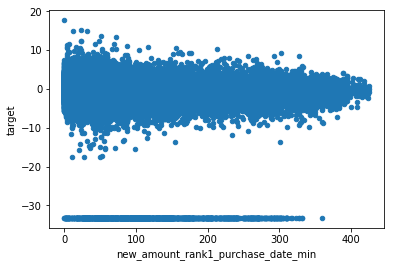

In [116]:
df_train.plot.scatter(x='new_amount_rank1_purchase_date_min',y='target')

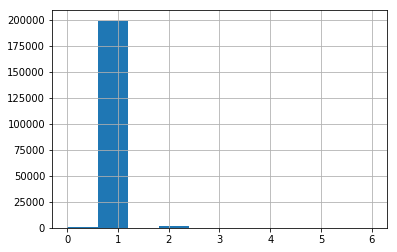

In [117]:
df_train['his_amount_rank1_merchant_id_nunique'].hist()

In [118]:
do_shuffle = True
random_seed = 2018
np.random.seed(random_seed) 

k = 5
fold1 = StratifiedKFold(n_splits = k, shuffle = do_shuffle, random_state = 2018).split(df_train, df_train['target'] < -30)
fold2 = StratifiedKFold(n_splits = k, shuffle = do_shuffle, random_state = 3018).split(df_train, df_train['target'] < -30)
    
results = []
for i, (trn, val) in enumerate(fold1) :
    print(i, 'fold')
    result = dict()
    result['trn_idx'] = trn
    result['val_idx'] = val
    results.append(result)
    
results2 = []
for i, (trn, val) in enumerate(fold2) :
    print(i, 'fold')
    result = dict()
    result['trn_idx'] = trn
    result['val_idx'] = val
    results2.append(result)
    
gc.collect()

0 fold
1 fold
2 fold
3 fold
4 fold
0 fold
1 fold
2 fold
3 fold
4 fold


329

In [119]:
seed 2018

seed 3018


SyntaxError: invalid syntax (<ipython-input-119-794092c1997e>, line 1)

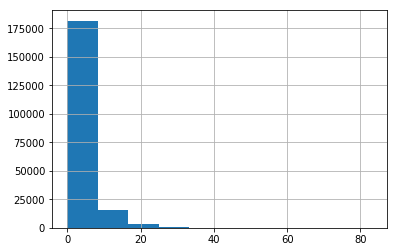

In [120]:
df_train['new_ca4_card_id_count'].hist()

In [121]:
[4168]	training's rmse: 3.1744	valid_1's rmse: 3.62666
[2624]	training's rmse: 3.29015	valid_1's rmse: 3.6277
    
[3599]	training's rmse: 3.21695	valid_1's rmse: 3.62226
[3034]	training's rmse: 3.25476	valid_1's rmse: 3.6463

SyntaxError: invalid syntax (<ipython-input-121-82000e351c54>, line 1)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


Training until validation scores don't improve for 1000 rounds.
[500]	training's rmse: 3.58299	valid_1's rmse: 3.68853
[1000]	training's rmse: 3.46758	valid_1's rmse: 3.65153
[1500]	training's rmse: 3.39829	valid_1's rmse: 3.64006
[2000]	training's rmse: 3.3499	valid_1's rmse: 3.63581
[2500]	training's rmse: 3.30755	valid_1's rmse: 3.63336
[3000]	training's rmse: 3.26985	valid_1's rmse: 3.63209
[3500]	training's rmse: 3.23423	valid_1's rmse: 3.63141
[4000]	training's rmse: 3.19969	valid_1's rmse: 3.63066
[4500]	training's rmse: 3.16718	valid_1's rmse: 3.63052
[5000]	training's rmse: 3.13581	valid_1's rmse: 3.63104
Early stopping, best iteration is:
[4339]	training's rmse: 3.17741	valid_1's rmse: 3.63049

Training until validation scores don't improve for 1000 rounds.
[500]	training's rmse: 3.58399	valid_1's rmse: 3.68558
[1000]	training's rmse: 3.47027	valid_1's rmse: 3.64756
[1500]	training's rmse: 3.40287	valid_1's rmse: 3.63667
[2000]	training's rmse: 3.35531	valid_1's rmse: 3.63302

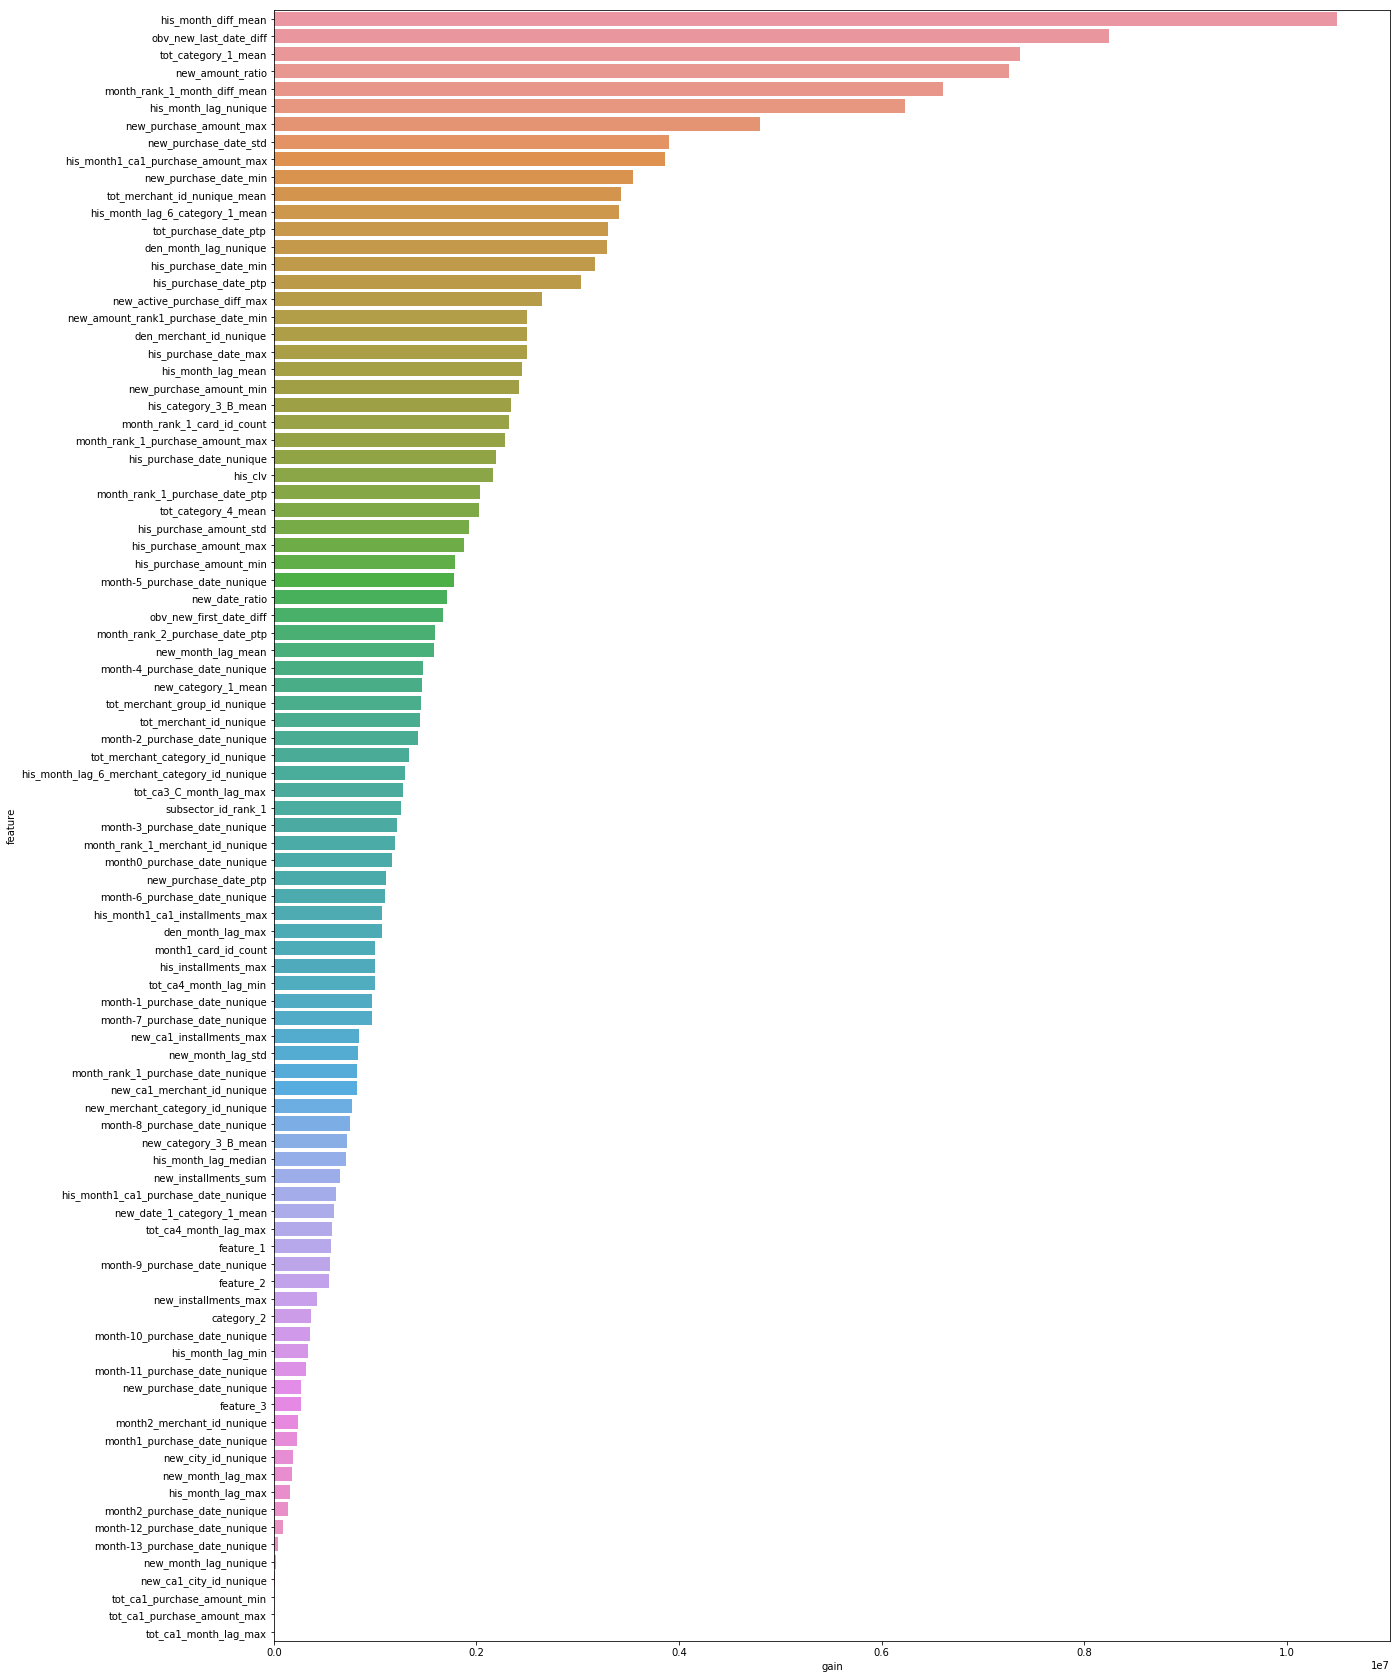

In [122]:
clip_threshold = -17.6
#clip_threshold = -40.6

param_out_clf = {'num_leaves': 120,
         'min_data_in_leaf': 40,   
         'objective':'binary',
         'min_gain_to_split' : 0.001,
         'max_depth': 9, #, 10
         'learning_rate': 0.002,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "random_state" : random_seed,
         "lambda_l1": 0.01,
         #"lambda_l2": 1.0,
         "verbosity": -1}
#param_out_clf['categorical_features'] = cat_cols

param = {'num_leaves': 110, #100 105저하
         'min_data_in_leaf': 40, #39 41저하
         'objective':'regression',
         'min_gain_to_split' : 0.001,
         'max_depth': 9, #, 8 10 11저하
         'learning_rate': 0.002,
         "boosting": "gbdt",
         "feature_fraction": 0.8, # 0.7 0.9저하
         "bagging_freq": 1,
         "bagging_fraction": 0.8, # 0.7 0.9저하
         "bagging_seed": 10,
         "metric": 'rmse',
         "random_state" : random_seed,
         "lambda_l1": 0.01, # 0.1 0.001저하
         #"lambda_l2": 0.01,#degrade
         "verbosity": -1}
#param['categorical_features'] = cat_cols

val_result = pd.DataFrame({'idx':[], 'target':[], 'reg_pred':[], 'reg_pred_no_outlier':[], 'clf_pred':[]})

for i, (result) in enumerate(results) :    
    
    #if i > 1 : break
    
    trn = result['trn_idx']
    val = result['val_idx']
    
    temp = pd.DataFrame()
    temp['idx'] = val
    temp['target'] = df_train.loc[val, 'target'].values.reshape(-1)
    
     # reg with outlier
    trn_y = df_train.loc[trn, 'target']
    val_y = df_train.loc[val, 'target']

    trn_x = df_train.loc[trn, features]
    val_x = df_train.loc[val, features]
    
    trn_data = lgb.Dataset(trn_x, label = trn_y)
    val_data = lgb.Dataset(val_x, label = val_y)
    
    record = dict()
    model = lgb.train(param
                      , trn_data
                      , num_boost_round = 100000
                      , valid_sets = [trn_data, val_data]
                      , verbose_eval = 500
                      , early_stopping_rounds = 1000
                      , callbacks = [lgb.record_evaluation(record)]
                     )
    result['reg_model'] = model
    min_val_idx = np.argmin(np.array(record['valid_1']['rmse']))
    result['reg_err_val'] = record['valid_1']['rmse'][min_val_idx]
    result['reg_imp'] = pd.DataFrame([(f, imp) for f, imp in zip(features, model.feature_importance('gain'))], columns=['feature', 'gain'])
    temp['reg_pred'] = model.predict(val_x, num_iteration = model.best_iteration)

    """
    #reg without outlier
    trn_y = df_train.loc[(df_train.index.isin(trn))&(df_train['target']>-30), 'target']
    val_y = df_train.loc[(df_train.index.isin(val))&(df_train['target']>-30), 'target']
    
    trn_x = df_train.loc[(df_train.index.isin(trn))&(df_train['target']>-30), features]
    val_x = df_train.loc[(df_train.index.isin(val))&(df_train['target']>-30), features]
    
    trn_data = lgb.Dataset(trn_x, label = trn_y)
    val_data = lgb.Dataset(val_x, label = val_y)
    
    record = dict()
    model = lgb.train(param
                      , trn_data
                      , num_boost_round = 100000
                      , valid_sets = [trn_data, val_data]
                      , verbose_eval = 500
                      , early_stopping_rounds = 1000
                      , callbacks = [lgb.record_evaluation(record)]
                     )
    result['reg_model_no_outlier'] = model
    temp['reg_pred_no_outlier'] = model.predict(df_train.loc[val, features], num_iteration = model.best_iteration)

    # outlier clf
    trn_y = (df_train.loc[trn, 'target'] < -30).astype(np.int8)
    val_y = (df_train.loc[val, 'target'] < -30).astype(np.int8)

    trn_x = df_train.loc[trn, features]
    val_x = df_train.loc[val, features]
    
    trn_data = lgb.Dataset(trn_x, label = trn_y)
    val_data = lgb.Dataset(val_x, label = val_y)
    
    record = dict()
    model = lgb.train(param_out_clf
                      , trn_data
                      , num_boost_round = 100000
                      , valid_sets = [trn_data, val_data]
                      , verbose_eval = 500
                      , early_stopping_rounds = 1000
                      , callbacks = [lgb.record_evaluation(record)]
                     )
    result['clf_model'] = model
    min_val_idx = np.argmin(np.array(record['valid_1']['binary_logloss']))
    result['clf_err_val'] = record['valid_1']['binary_logloss'][min_val_idx]
    result['clf_imp'] = pd.DataFrame([(f, imp) for f, imp in zip(features, model.feature_importance('gain'))], columns=['feature', 'gain'])
    temp['clf_pred'] = model.predict(val_x, num_iteration = model.best_iteration)

    val_result = pd.concat([val_result, temp])
    """
    ##print(temp.sort_values(by=['reg_pred']).head(10))
    
    del model
    gc.collect()
    print("")
    
print([result['reg_err_val'] for result in results if 'reg_err_val' in result])
print('avg rmse error :', sum([result['reg_err_val'] for result in results if 'reg_err_val' in result]) / len([result['reg_err_val'] for result in results if 'reg_err_val' in result]))
print("Done")

plt.figure(figsize=(20, 30))
sns_plot = sns.barplot(x="gain", y="feature", data=pd.concat([r['reg_imp'] for r in results if 'reg_imp' in r]).groupby('feature').agg({'gain':'mean'}).sort_values(by='gain', ascending=False).reset_index())
plt.savefig("imp.png")

In [147]:
features_real=[]
for feat in features:
    if feat in df_train.columns.tolist():
        features_real.append(feat)
    else:
        print(feat)
        

tot_ca1_month_lag_max
tot_ca1_purchase_amount_min
tot_ca1_purchase_amount_max


In [150]:
df_train[features_real].to_csv('train_kim.csv',index=False)
df_test[features_real].to_csv('test_kim.csv',index=False)

In [133]:
len(features)

93

In [124]:
df_train['new_amount_rank1_merchant_id_nunique']

0         2.0
1         1.0
2         1.0
3         1.0
4         1.0
5         1.0
6         1.0
7         1.0
8         1.0
9         1.0
10        1.0
11        1.0
12        1.0
13        1.0
14        1.0
15        0.0
16        1.0
17        1.0
18        1.0
19        1.0
20        1.0
21        0.0
22        1.0
23        1.0
24        1.0
25        0.0
26        1.0
27        1.0
28        1.0
29        1.0
         ... 
201887    1.0
201888    1.0
201889    1.0
201890    1.0
201891    1.0
201892    1.0
201893    1.0
201894    1.0
201895    1.0
201896    1.0
201897    1.0
201898    1.0
201899    0.0
201900    1.0
201901    1.0
201902    1.0
201903    0.0
201904    1.0
201905    1.0
201906    1.0
201907    1.0
201908    1.0
201909    1.0
201910    1.0
201911    1.0
201912    1.0
201913    1.0
201914    1.0
201915    1.0
201916    1.0
Name: new_amount_rank1_merchant_id_nunique, Length: 201917, dtype: float16

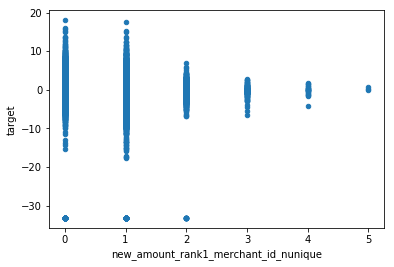

In [125]:
df_train.plot.scatter(x='new_amount_rank1_merchant_id_nunique',y='target')

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  app.launch_new_instance()
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


Training until validation scores don't improve for 1000 rounds.
[2000]	training's rmse: 3.35773	valid_1's rmse: 3.62739
[4000]	training's rmse: 3.20584	valid_1's rmse: 3.62336
Early stopping, best iteration is:
[3756]	training's rmse: 3.22227	valid_1's rmse: 3.62325

Training until validation scores don't improve for 1000 rounds.
[2000]	training's rmse: 3.34807	valid_1's rmse: 3.65459
Early stopping, best iteration is:
[2898]	training's rmse: 3.27629	valid_1's rmse: 3.6534

[3.623248619614801, 3.653395752108461]
avg rmse error : 3.638322185861631
Done


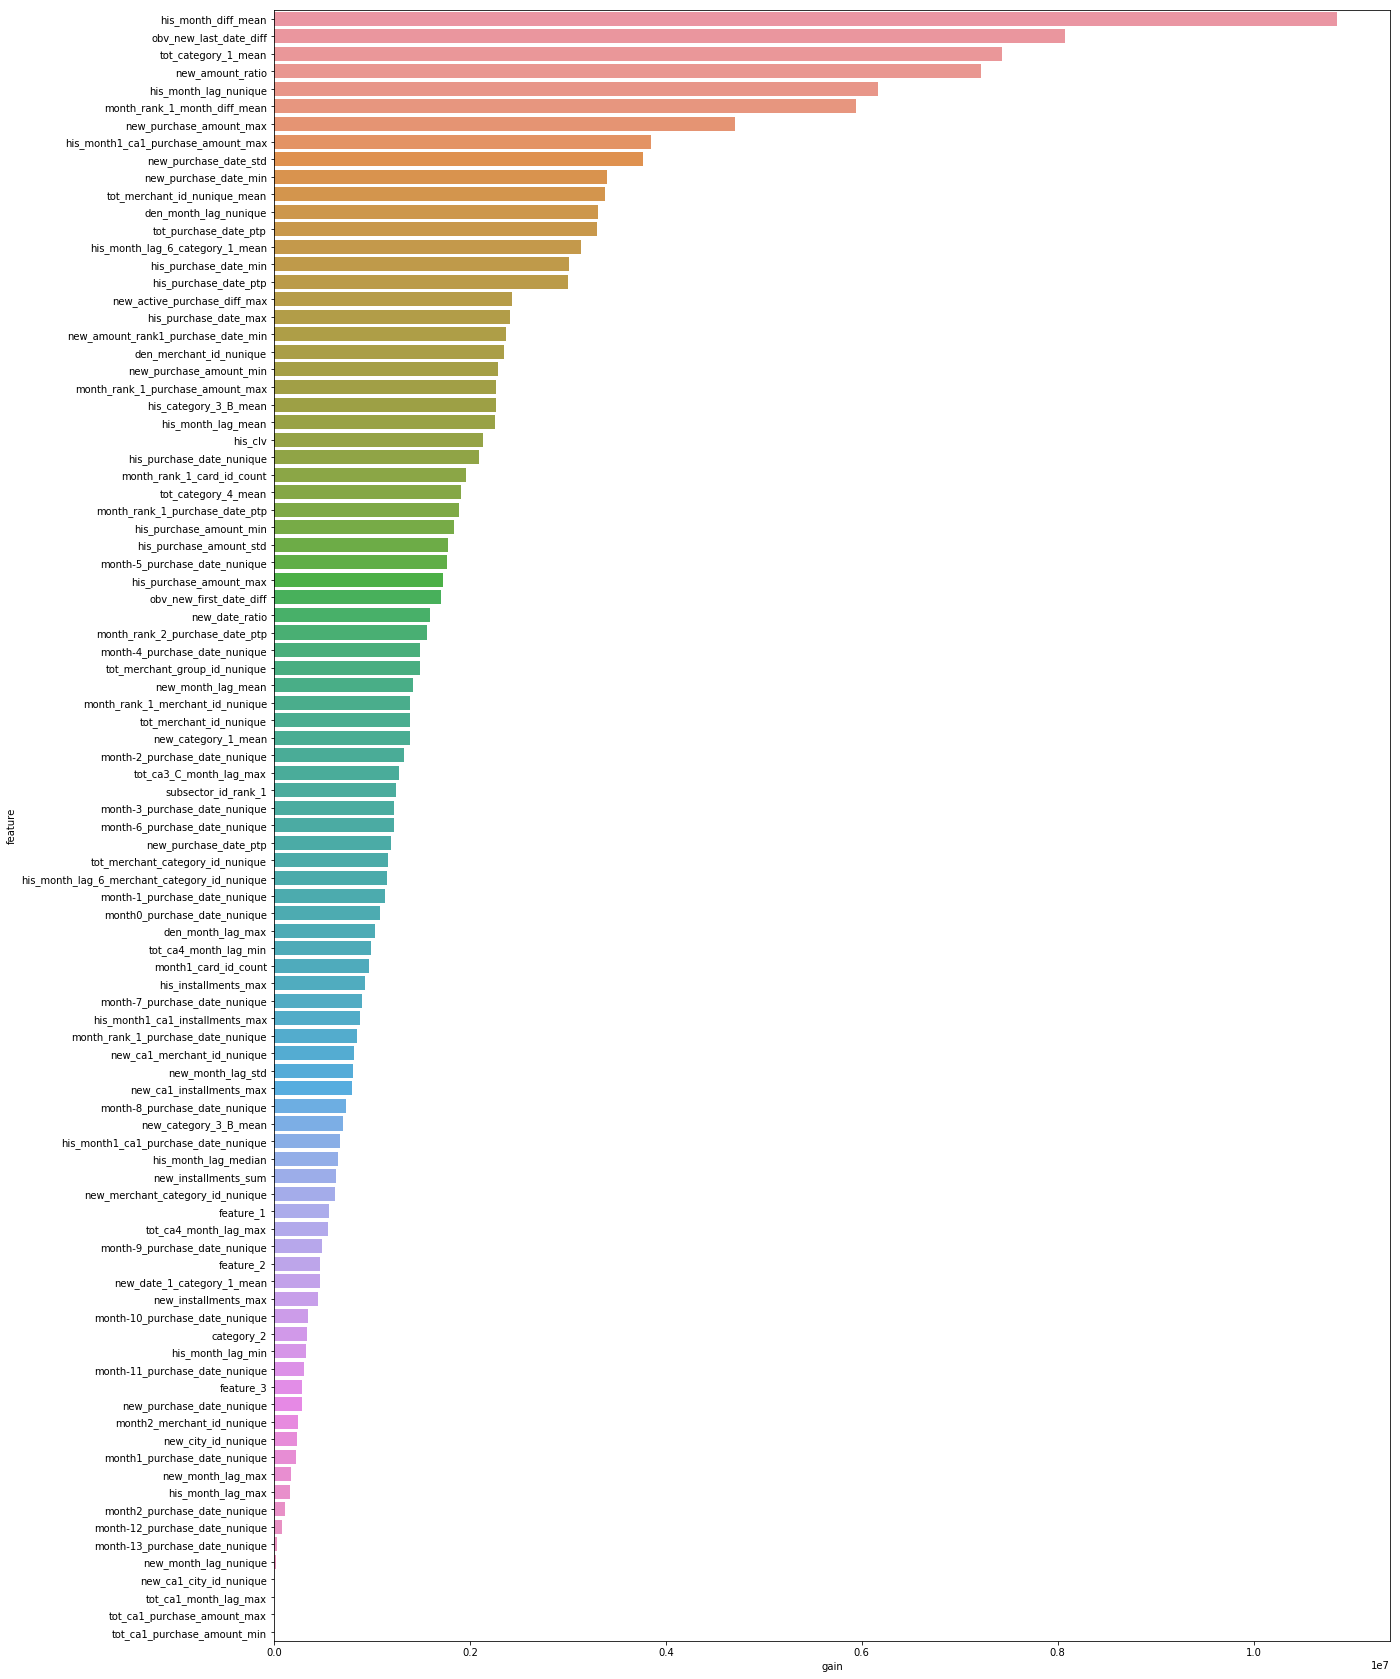

In [126]:
for i, (result) in enumerate(results2) :
    
    if i > 1 : break
    
    trn = result['trn_idx']
    val = result['val_idx']
    
    temp = pd.DataFrame()
    temp['idx'] = val
    temp['target'] = df_train.loc[val, 'target'].values.reshape(-1)
    
     # reg with outlier
    trn_y = df_train.loc[trn, 'target']
    val_y = df_train.loc[val, 'target']

    trn_x = df_train.loc[trn, features]
    val_x = df_train.loc[val, features]
    
    trn_data = lgb.Dataset(trn_x, label = trn_y)
    val_data = lgb.Dataset(val_x, label = val_y)
    
    record = dict()
    model = lgb.train(param
                      , trn_data
                      , num_boost_round = 100000
                      , valid_sets = [trn_data, val_data]
                      , verbose_eval = 2000
                      , early_stopping_rounds = 1000
                      , callbacks = [lgb.record_evaluation(record)]
                     )
    result['reg_model'] = model
    min_val_idx = np.argmin(np.array(record['valid_1']['rmse']))
    result['reg_err_val'] = record['valid_1']['rmse'][min_val_idx]
    result['reg_imp'] = pd.DataFrame([(f, imp) for f, imp in zip(features, model.feature_importance('gain'))], columns=['feature', 'gain'])
    temp['reg_pred'] = model.predict(val_x, num_iteration = model.best_iteration)

    #print(temp.sort_values(by=['reg_pred']).head(10))
    
    del model
    gc.collect()
    print("")
    
    
print([result['reg_err_val'] for result in results2 if 'reg_err_val' in result])
print('avg rmse error :', sum([result['reg_err_val'] for result in results2 if 'reg_err_val' in result]) / len([result['reg_err_val'] for result in results2 if 'reg_err_val' in result]))
print("Done")

plt.figure(figsize=(20, 30))
sns_plot = sns.barplot(x="gain", y="feature", data=pd.concat([r['reg_imp'] for r in results2 if 'reg_imp' in r]).groupby('feature').agg({'gain':'mean'}).sort_values(by='gain', ascending=False).reset_index())
plt.savefig("imp.png")

In [127]:
def find_best_result(pred_with_out, pred_without_out, prob, target) :
    rmse = []
    threshold = []
    
    pred_with_out = pred_with_out.copy()
    pred_without_out = pred_without_out.copy()
    prob = prob.copy()
    
    for t in np.arange(0.0, 1.01, 0.001) :
        pred_dummy = pred_without_out.copy()
        out_idx = np.where(prob>=t)[0]
        pred_dummy[out_idx] = pred_with_out[out_idx]
        rmse.append(get_rmse(target, pred_dummy))
        threshold.append(t)

    best_idx = np.argmin(np.array(rmse))
    return rmse[best_idx], threshold[best_idx]

final_error_avg = 0
final_pred = np.zeros(df_test.shape[0])

for i, (result) in enumerate(results) :
    print(i, "fold.")
    df = val_result.loc[val_result['idx'].isin(result['val_idx']), :].copy()
    
    print("init rmse(1) with outlier    :", result['reg_err_val'])
    print("init rmse(2) without outlier :", get_rmse(df['reg_pred_no_outlier'].values, df['target'].values))
    
    print("mix of rmse(1) and rmse(2)")
    rmse, threshold = find_best_result(df['reg_pred'].values, df['reg_pred_no_outlier'].values, df['clf_pred'].values, df['target'].values)
    print("best rmse :", rmse, " at", threshold, " threshold") 
    
    print('')
    
    df['final_pred'] = df['reg_pred_no_outlier'].values
    
    print("[phase_1] mixing rmse(2) with mean of rmse(1), rmse(2)..")
    rmse, threshold1 = find_best_result(df['reg_pred'].values*0.5+df['reg_pred_no_outlier'].values*0.5, df['final_pred'].values, df['clf_pred'].values, df['target'].values)
    print("best rmse :", rmse, " at", threshold1, " threshold", end = "\n\n") 
    
    idx = df['clf_pred'] >= threshold1
    df.loc[idx, 'final_pred'] = (df.loc[idx, 'reg_pred'] + df.loc[idx, 'reg_pred_no_outlier'])/2
    
    print("[phase_2] mixing phase_1 result with rmse(1)..")
    rmse, threshold2 = find_best_result(df['reg_pred'], df['final_pred'].values, df['clf_pred'].values, df['target'].values)
    print("best rmse :", rmse, " at", threshold2, " threshold", end = "\n\n") 
    
    idx = df['clf_pred'] >= threshold2
    df.loc[idx, 'final_pred'] = df.loc[idx, 'reg_pred']

    #print("lowest prediction ajdusting...")
    #out_threshold = df.sort_values(by='final_pred')['final_pred'].values[0]
    #print(df.loc[df['final_pred']<=out_threshold, :])
    #df.loc[df['final_pred']<=out_threshold, 'final_pred'] = -33.218750
    
    final_error = get_rmse(df['final_pred'].values, df['target'].values)
    print("final error :", final_error, end = "\n\n")
    final_error_avg += final_error / k

    if use_ffm : df_test.loc[:, ffm_latent_cols] = get_ffm_vect(field_dict, df_test_onehot.values, result['reg_ffm_weight'])
    
    test_pred = pd.DataFrame()
    test_pred['reg_pred'] = result['reg_model'].predict(df_test[features], num_iteration = result['reg_model'].best_iteration).reshape(-1)
    test_pred['reg_pred_no_outlier'] = result['reg_model_no_outlier'].predict(df_test[features], num_iteration = result['reg_model_no_outlier'].best_iteration).reshape(-1)
    test_pred['clf_pred'] = result['clf_model'].predict(df_test[features], num_iteration = result['clf_model'].best_iteration).reshape(-1)
    
    test_pred['final_pred'] = test_pred['reg_pred_no_outlier']
    
    idx = test_pred['clf_pred'] >= threshold1
    test_pred.loc[idx, 'final_pred'] = (test_pred.loc[idx, 'reg_pred'] + test_pred.loc[idx, 'reg_pred_no_outlier']) / 2
    
    idx = test_pred['clf_pred'] >= threshold2
    test_pred.loc[idx, 'final_pred'] = test_pred.loc[idx, 'reg_pred']
    
    out_threshold = test_pred.sort_values(by='final_pred')['final_pred'].values[15]
    test_pred.loc[test_pred['final_pred']<=out_threshold, 'final_pred'] = -33.218750
    print(test_pred.loc[test_pred['final_pred']<=out_threshold, :])
    
    out_threshold = test_pred.sort_values(by='clf_pred', ascending = False)['clf_pred'].values[10]
    print(test_pred.loc[test_pred['clf_pred']>=out_threshold, :])
    test_pred.loc[test_pred['clf_pred']>=out_threshold, 'final_pred'] = -33.218750
    
    final_pred += test_pred['final_pred'].values.reshape(-1) / k

    print("---------------------------------------------------")
    
print("Average final error :", final_error_avg)

0 fold.
init rmse(1) with outlier    : 3.6304910791741345


C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


init rmse(2) without outlier : nan
mix of rmse(1) and rmse(2)
best rmse : nan  at 0.0  threshold

[phase_1] mixing rmse(2) with mean of rmse(1), rmse(2)..
best rmse : nan  at 0.0  threshold

[phase_2] mixing phase_1 result with rmse(1)..
best rmse : nan  at 0.0  threshold

final error : nan



NameError: name 'use_ffm' is not defined

In [128]:
final_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
submission = pd.DataFrame()
submission['card_id'] = df_test['card_id'].values
submission['target'] = final_pred
submission.to_csv('submission.csv', index = False)
submission['target'].hist()
plt.show()
submission.head()